In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt

from skyfield.api import load, Topos
from datetime import datetime
from datetime import timedelta
from datetime import timezone

Given the location of a ground station, compute its azimuth and altitude for the 120s interval. Exclude the satellite if it is below the horizon.

In [2]:
PWM_MIN = 5
PWM_MAX = 35

DURATION = 120

def deg_to_pwm(deg):
    return np.interp(deg, (0, 180), (PWM_MIN, PWM_MAX))

satellites = load.tle_file("active.txt")
sats = { sat.name: sat for sat in satellites }

data = {
    "lat": "48.25 N",
    "lon": "-79.0332 E",
    "start_time": 1586841905.907088
}

gs = Topos(data["lat"], data["lon"])

basetime = datetime.utcfromtimestamp(data["start_time"]).replace(tzinfo=timezone.utc)
times = [basetime + timedelta(seconds=i) for i in range(DURATION)]
ts = load.timescale()

def calc_pwm(sat):
    out_az = []
    out_alt = []
    
    t = ts.utc(times)

    topocentric = (sat - gs).at(t)

    alt, az, distance = topocentric.altaz()

    alt = alt.degrees
    az = az.degrees

    # satellite is not visible, exclude it
    for val in alt:
        if val < 0 or val > 180:
            return False, [], []

    for i, val in enumerate(az):
        if val > 180:
            az[i] -= 180
            alt[i] = 180 - alt[i]

    az_pwm = deg_to_pwm(az)
    alt_pwm = deg_to_pwm(alt)
    
    return True, az_pwm, alt_pwm

sat_df = {}
for sat in satellites:
    succeed, az, alt = calc_pwm(sat)
    if not succeed:
        continue
    sat_df[sat.name] = pd.concat((pd.Series(az), pd.Series(alt)), axis="columns").rename(columns={0: "az", 1: "alt"})

In [3]:
def plot_sat(data, label=""):
    az = data["az"]
    alt = data["alt"]
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    
    sb.scatterplot(data=az, ax=axs[0])
    sb.scatterplot(data=alt, ax=axs[0])
    sb.scatterplot(x=az, y=alt, ax=axs[1])
    
    axs[0].set_xlabel("time")
    
    axs[1].set_xlabel("Az")
    axs[1].set_xlabel("Alt")
    fig.suptitle(label)
    plt.show()

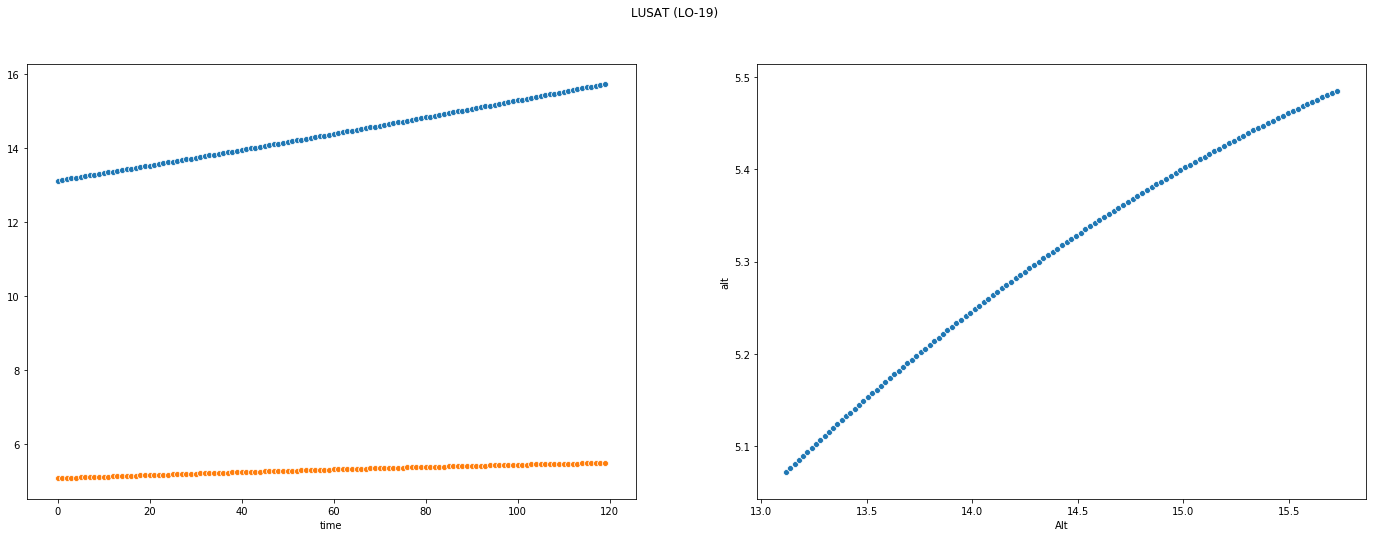

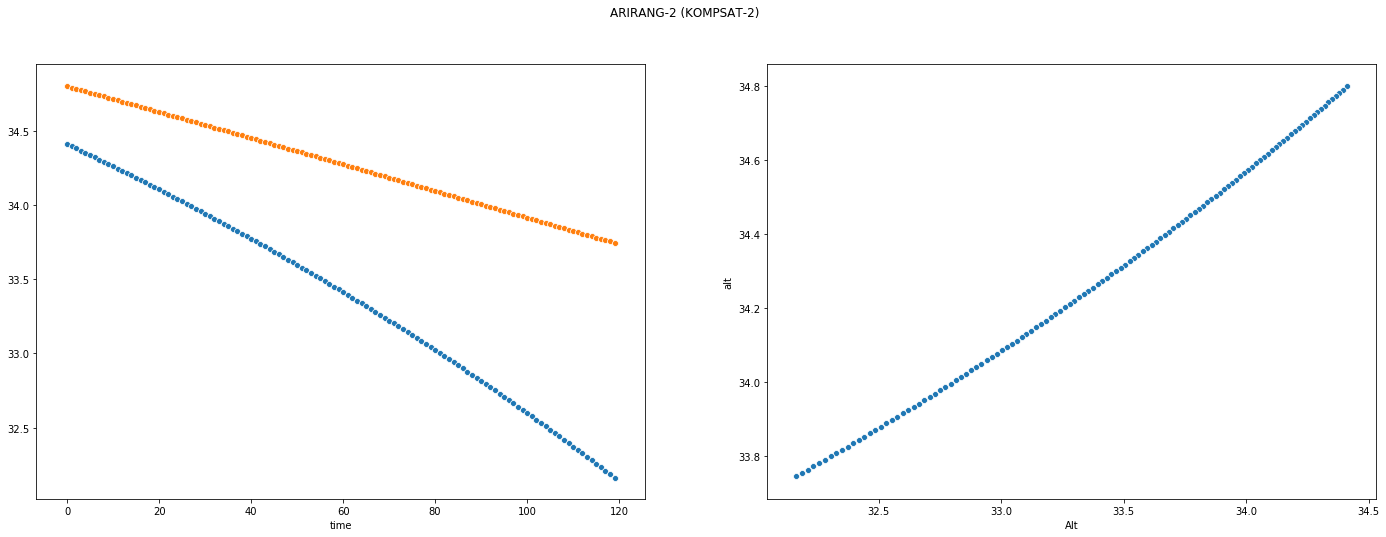

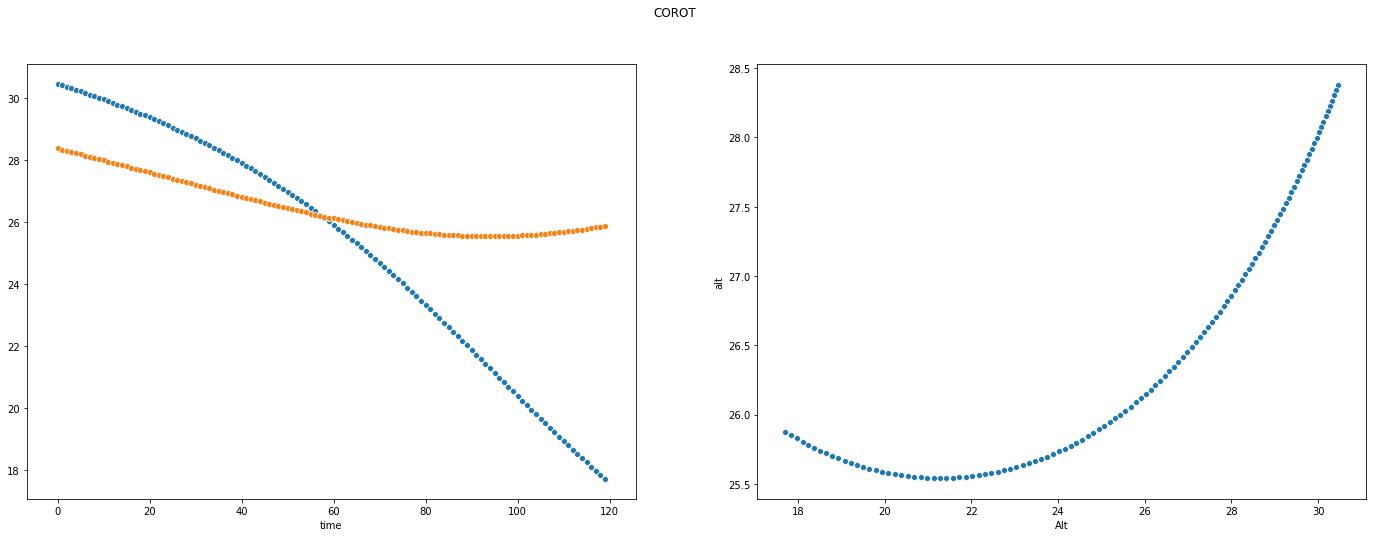

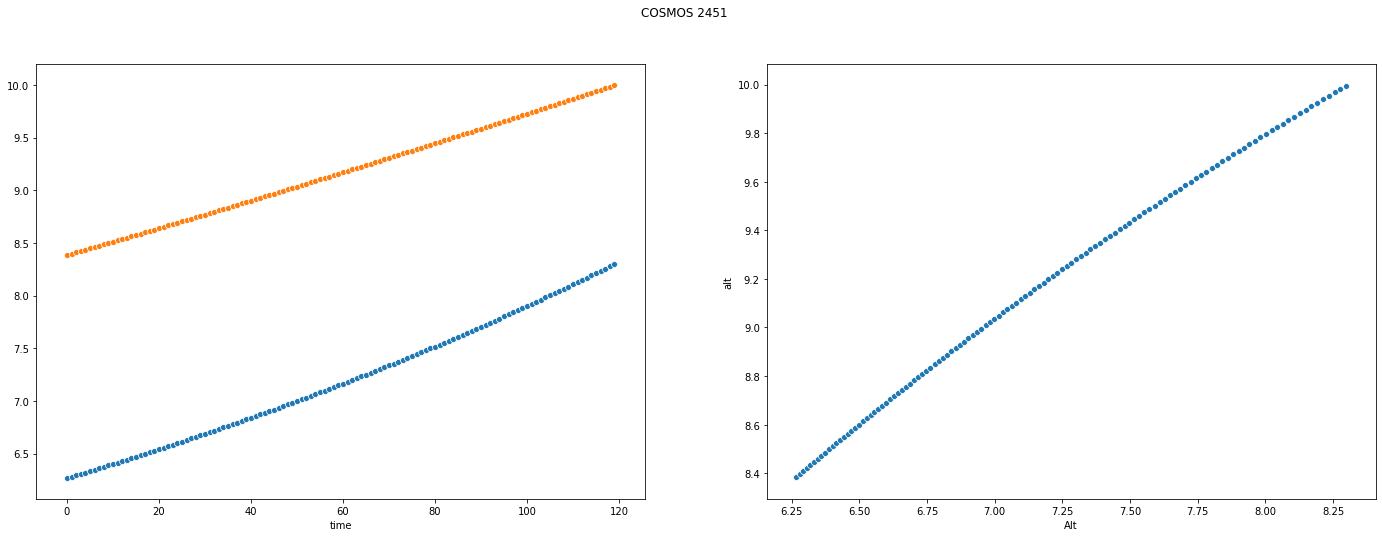

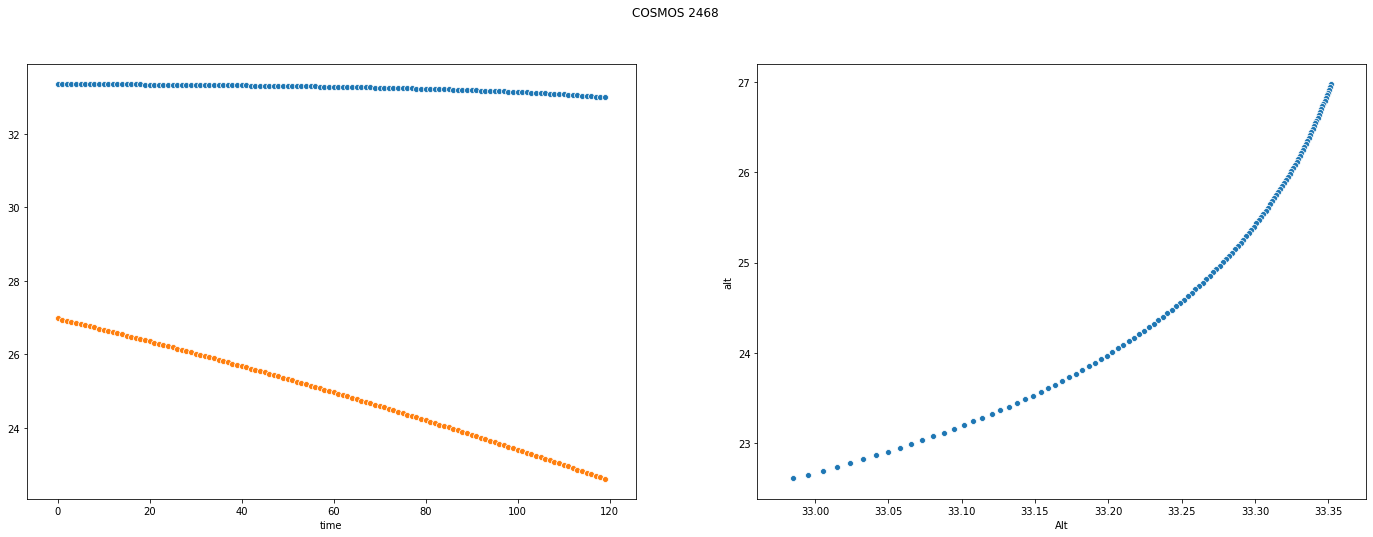

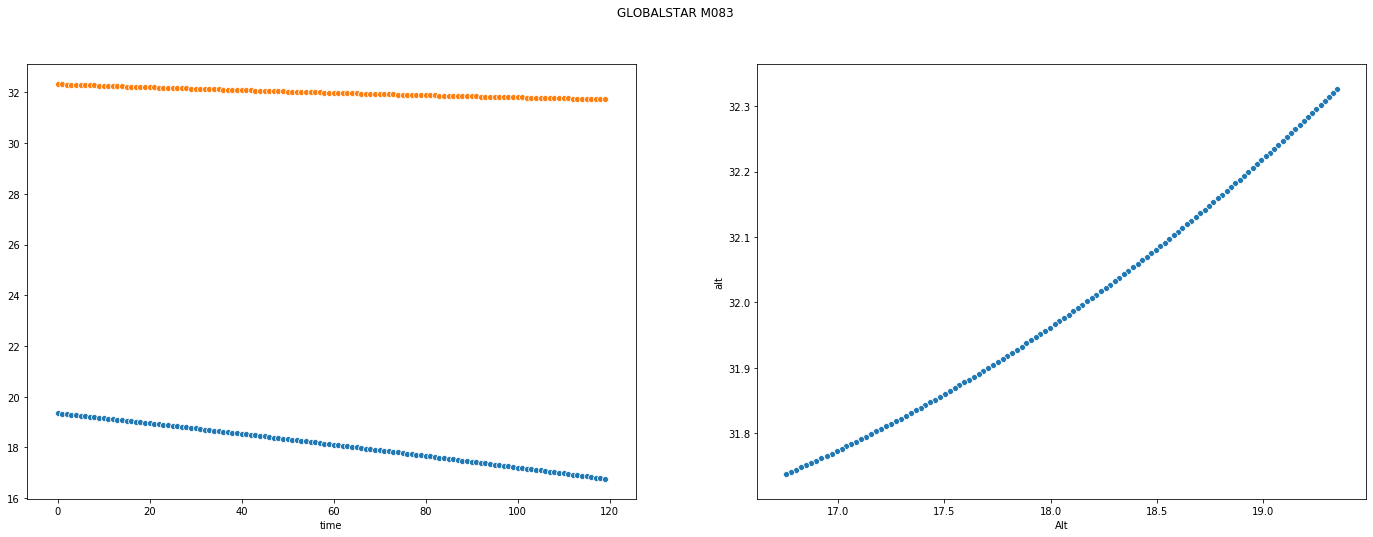

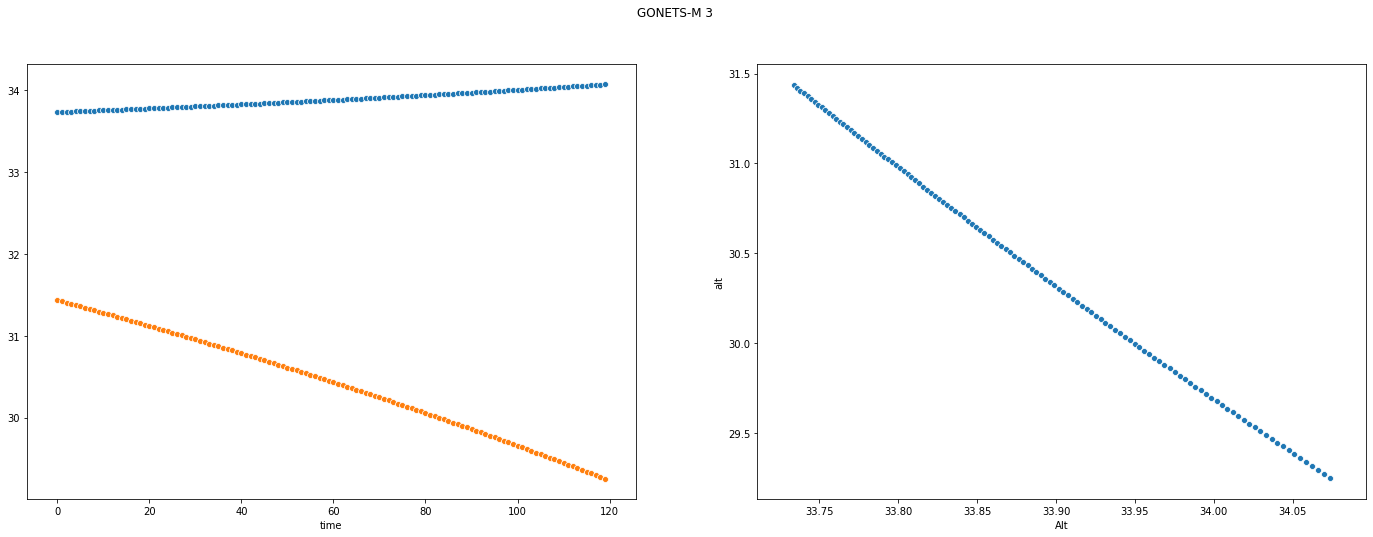

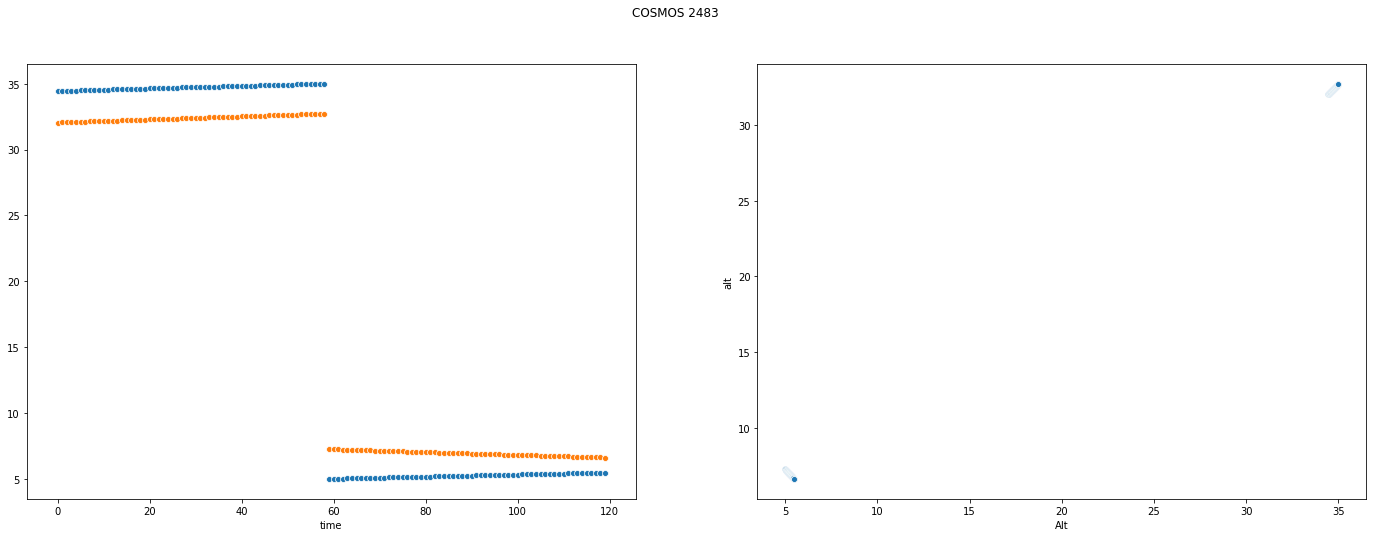

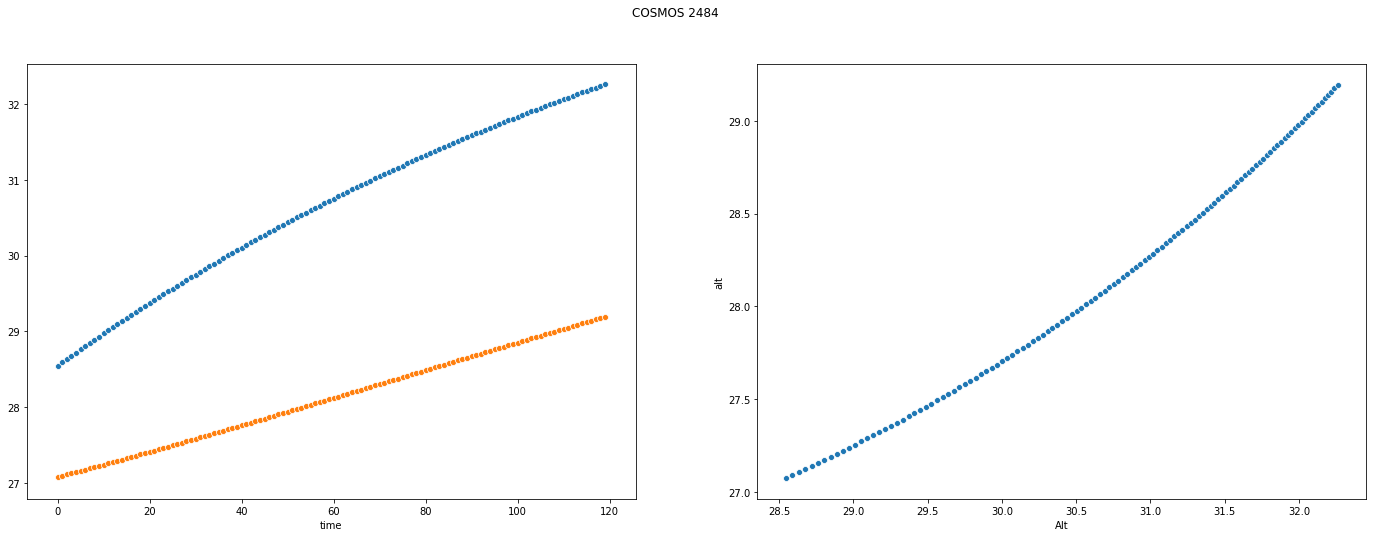

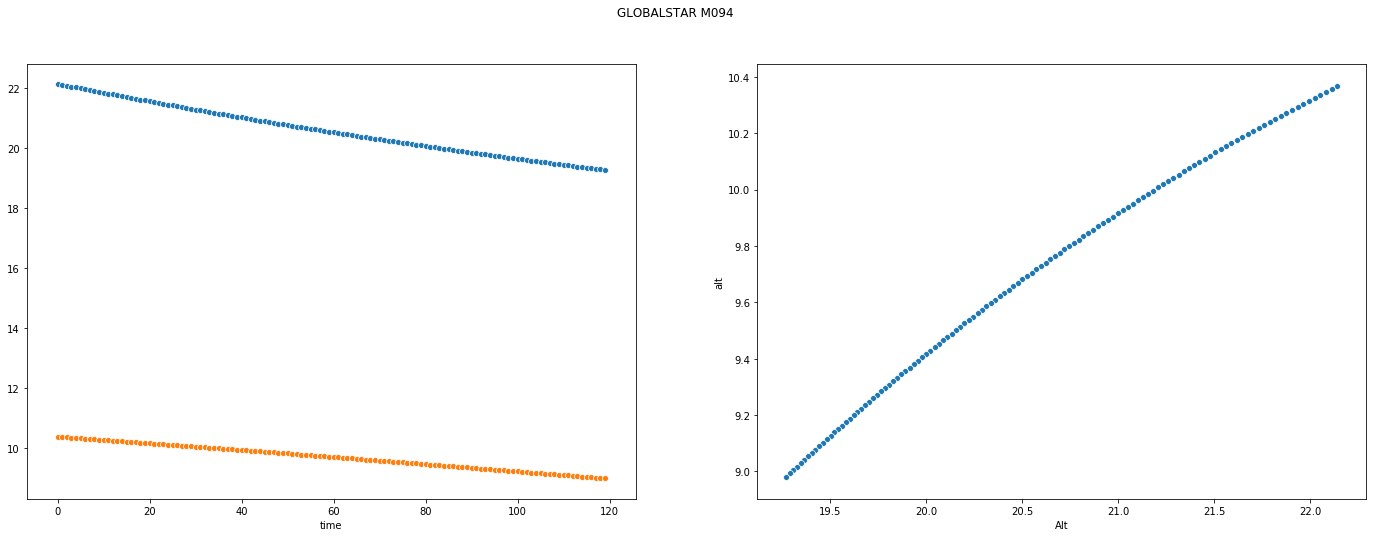

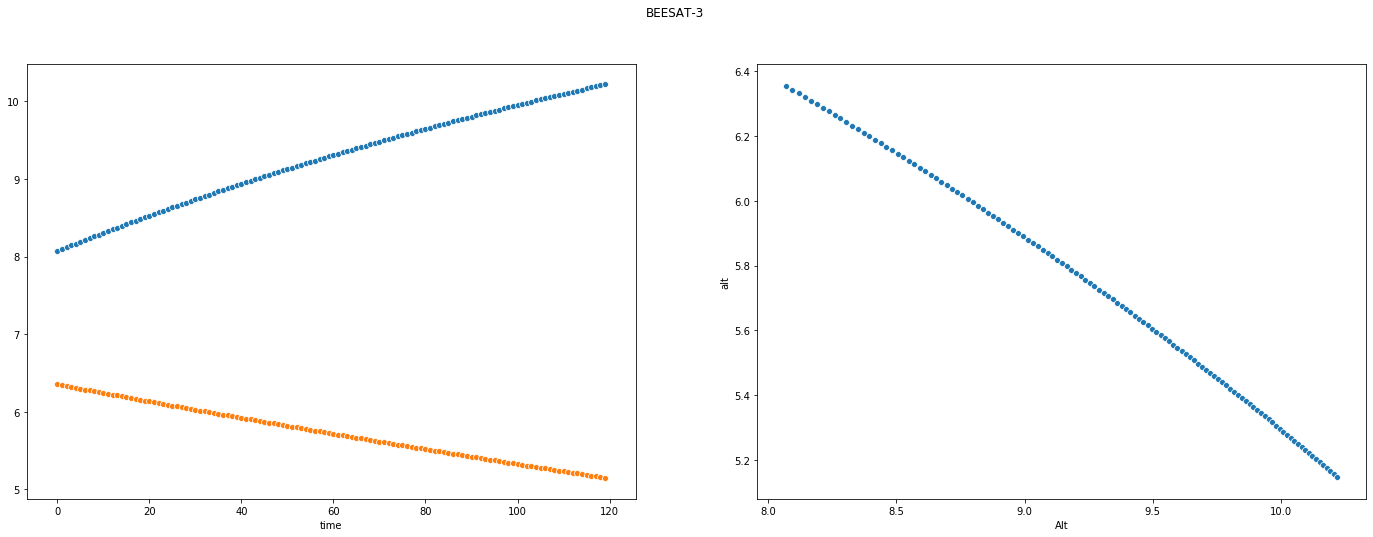

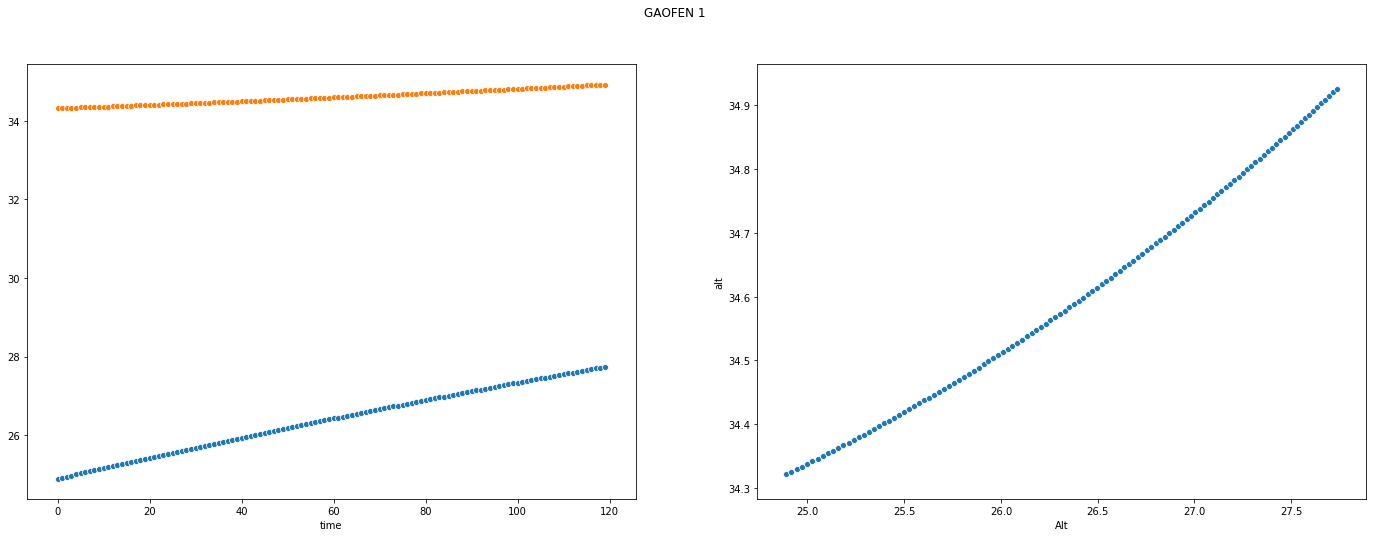

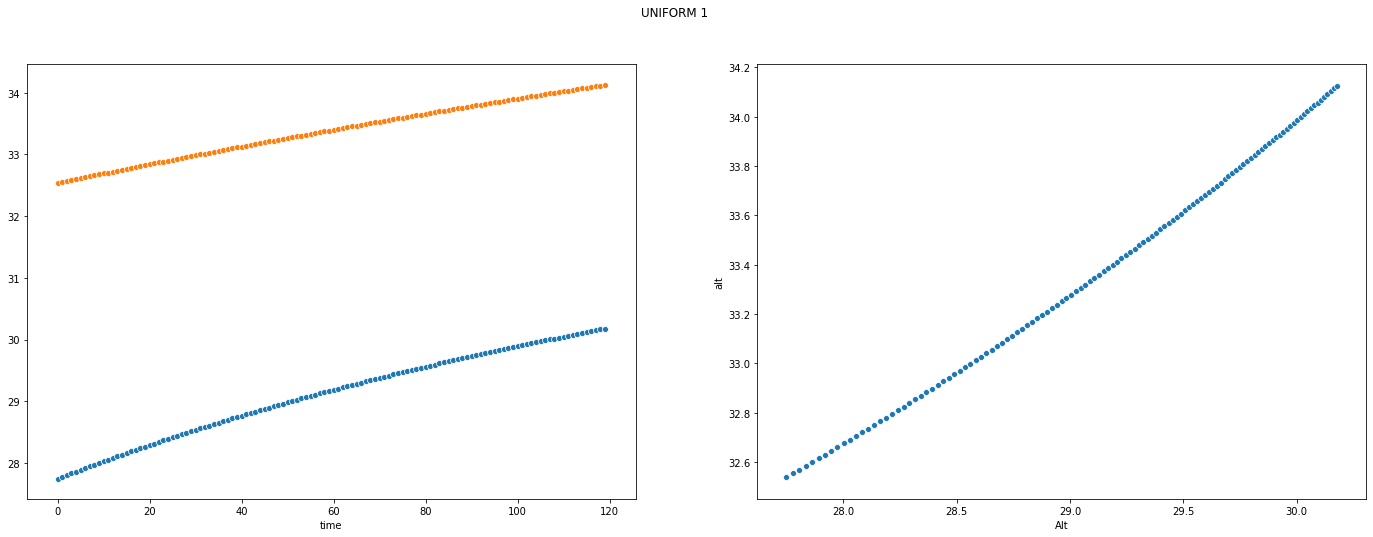

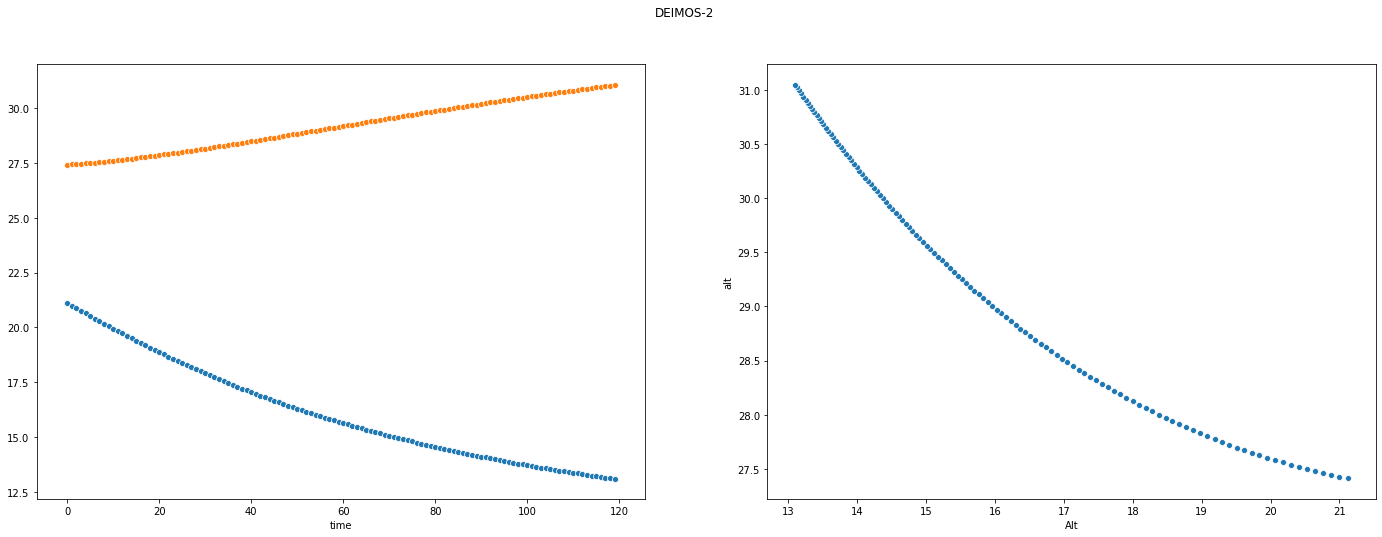

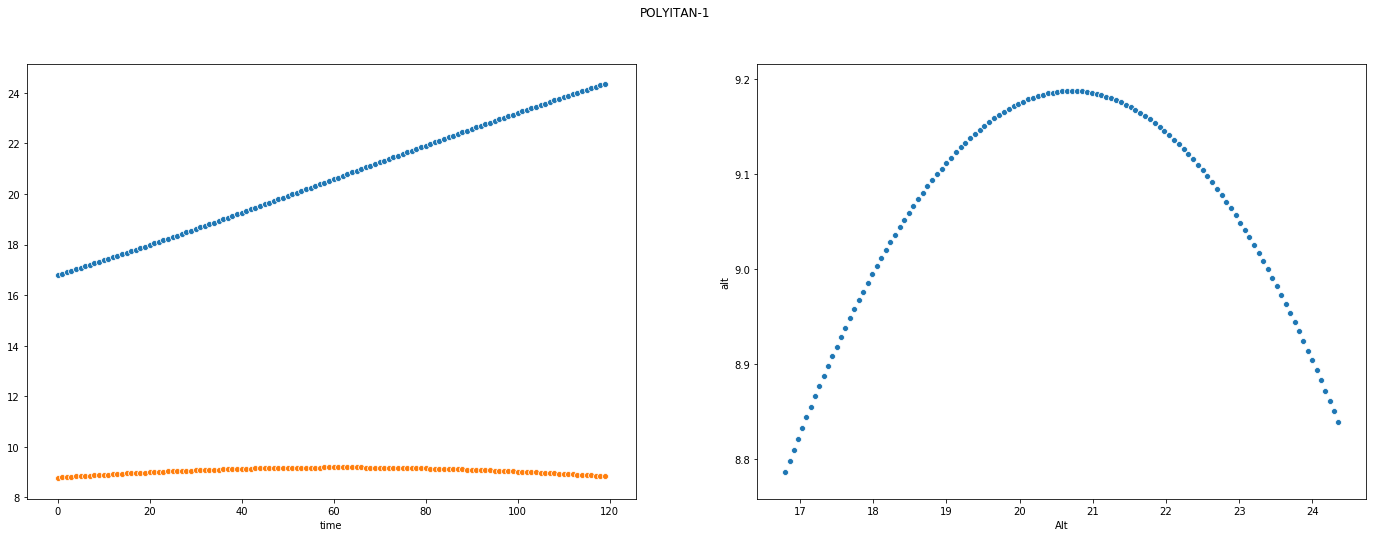

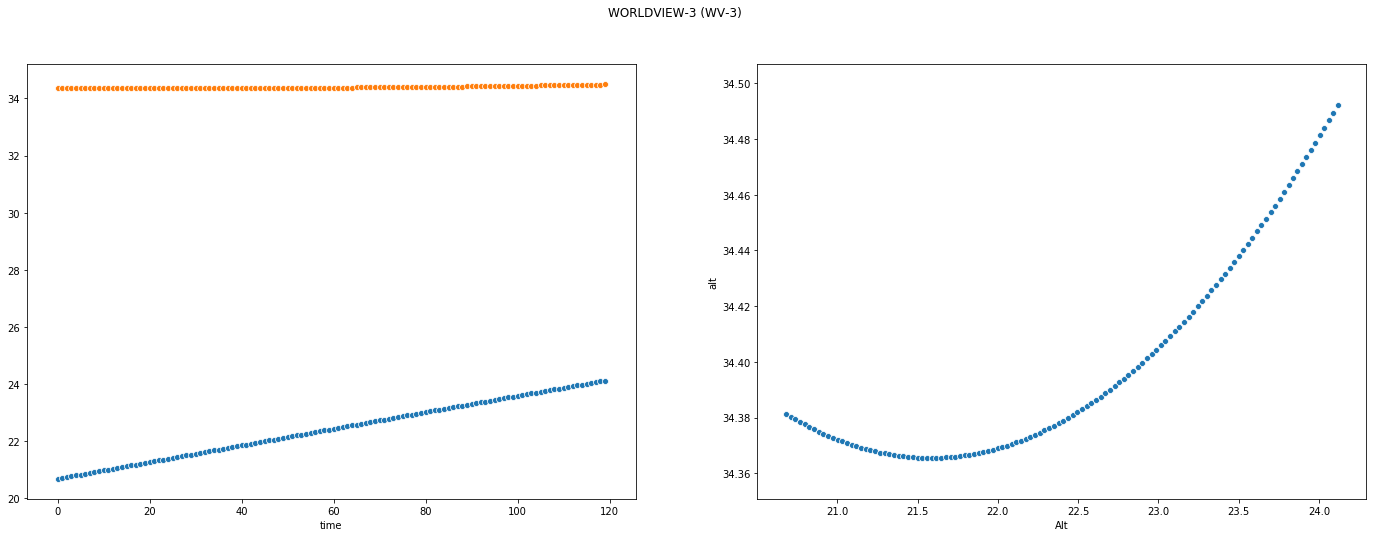

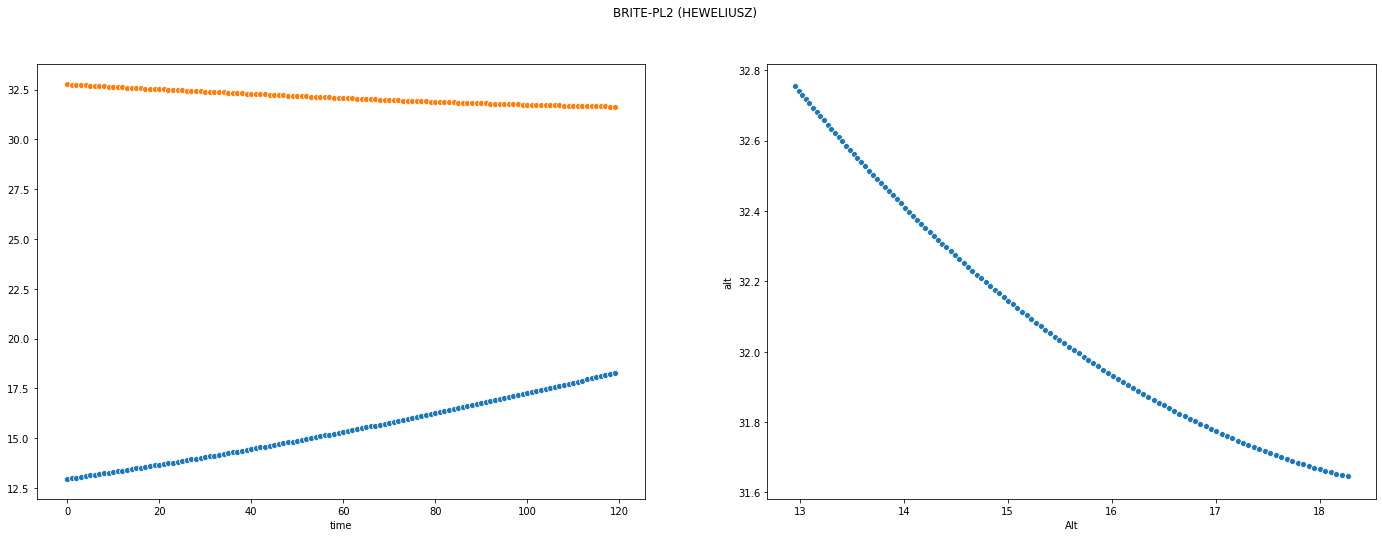

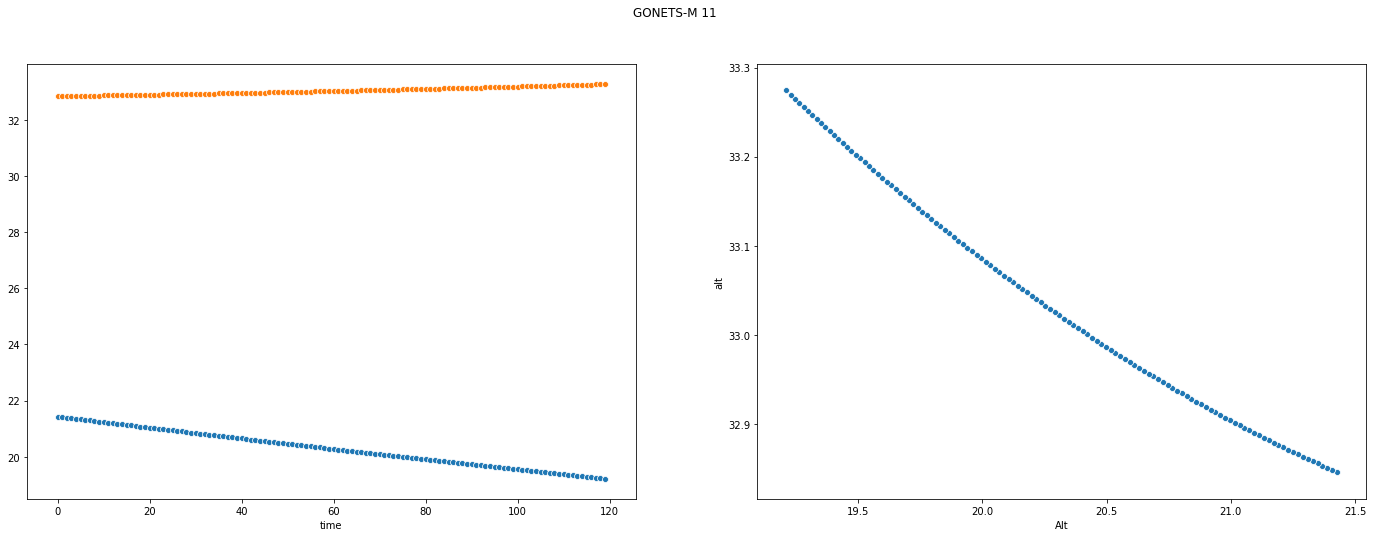

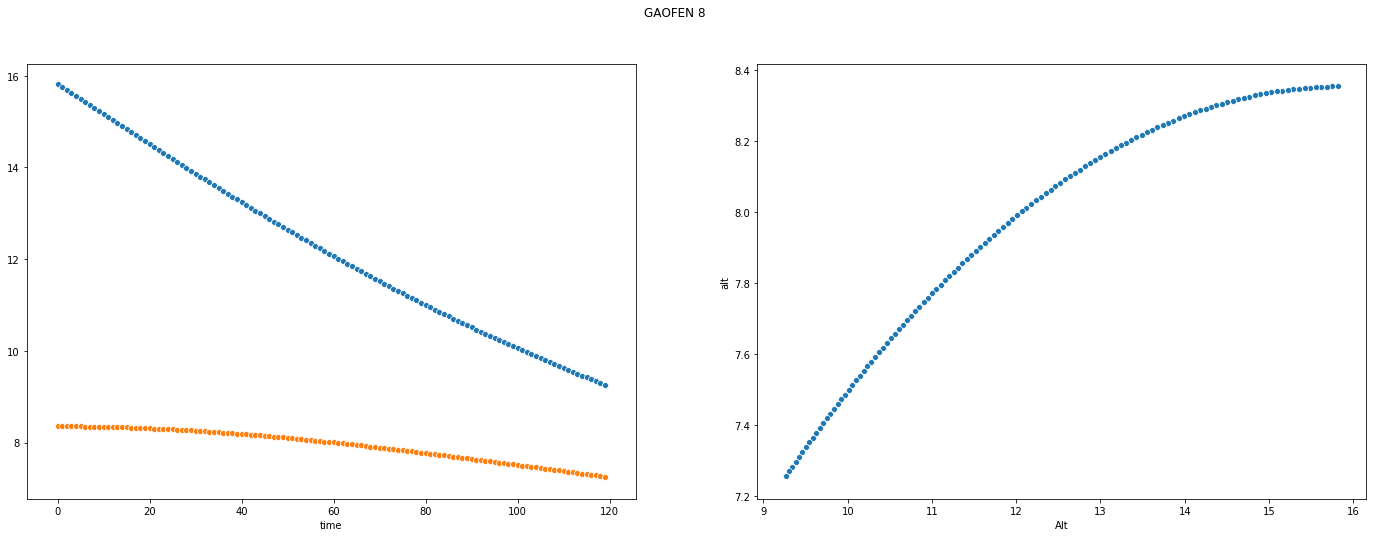

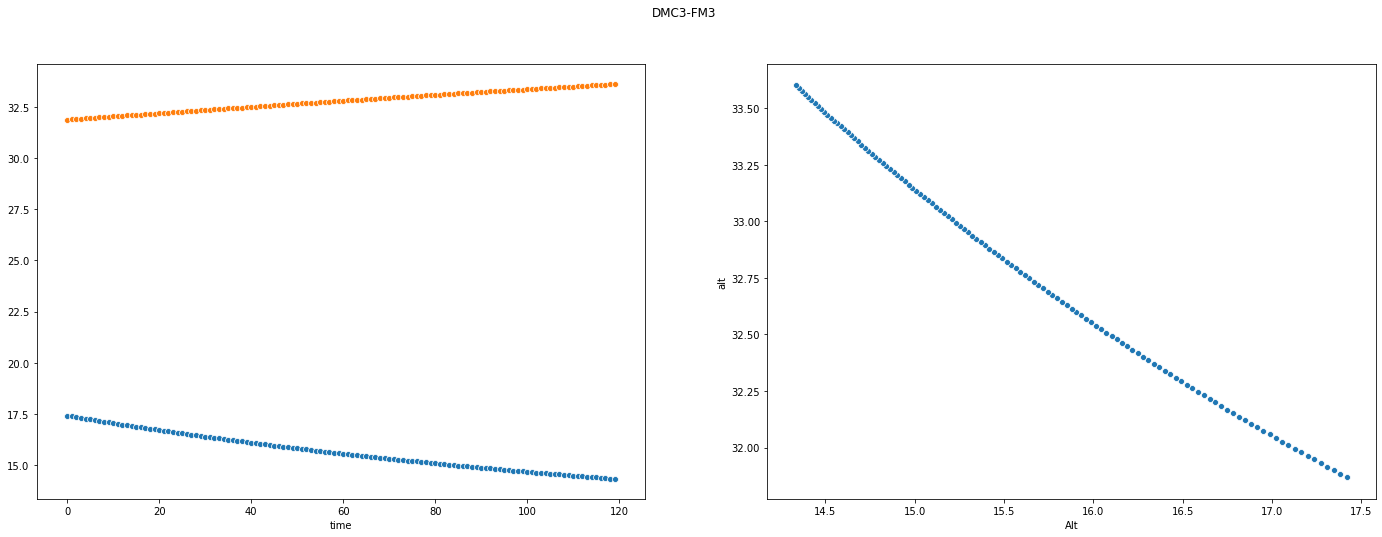

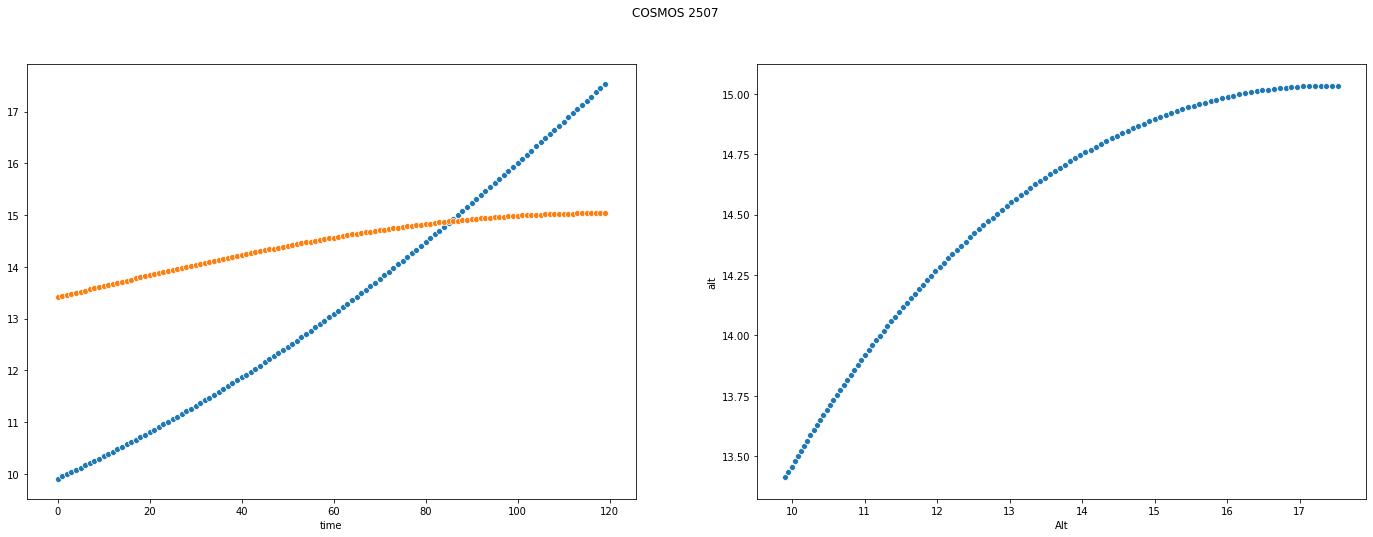

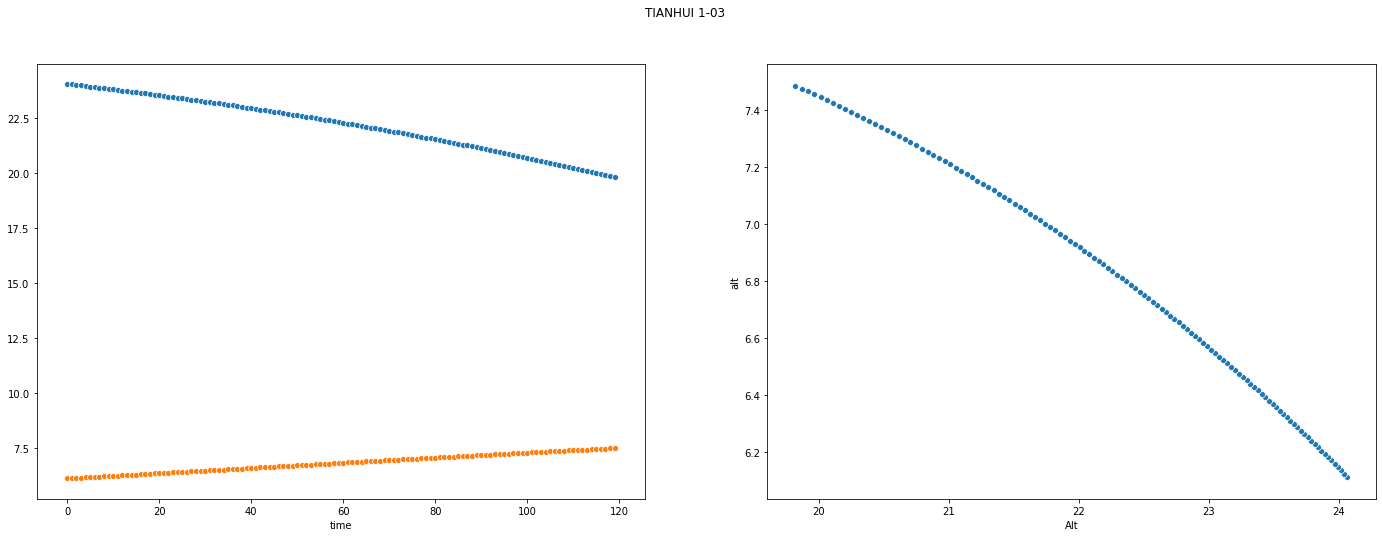

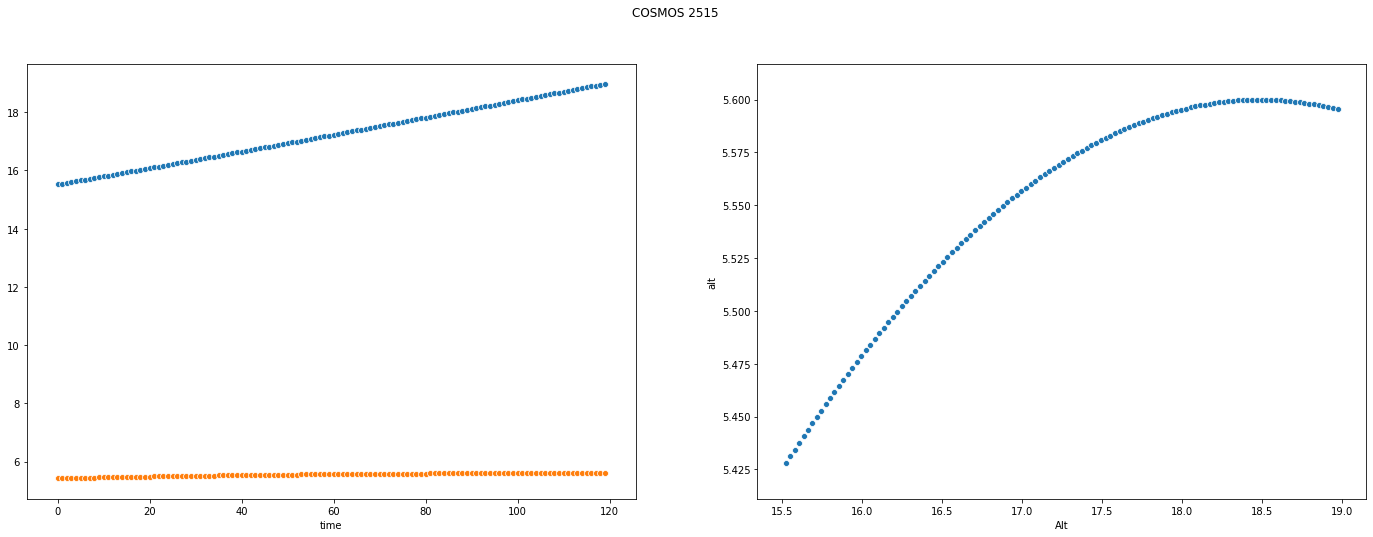

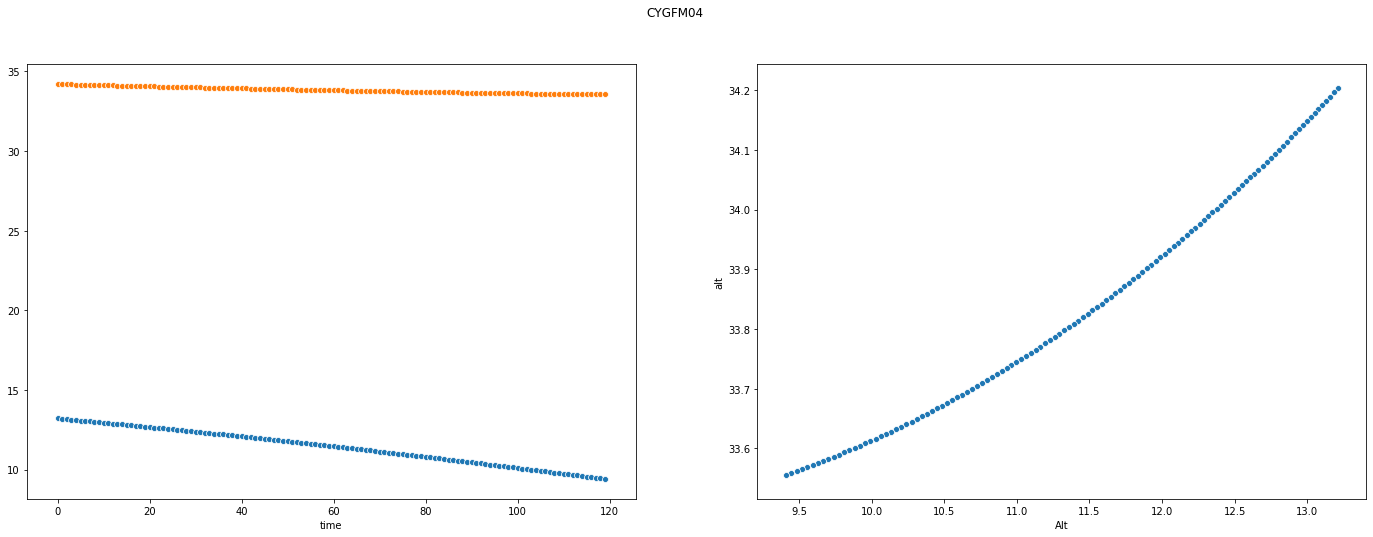

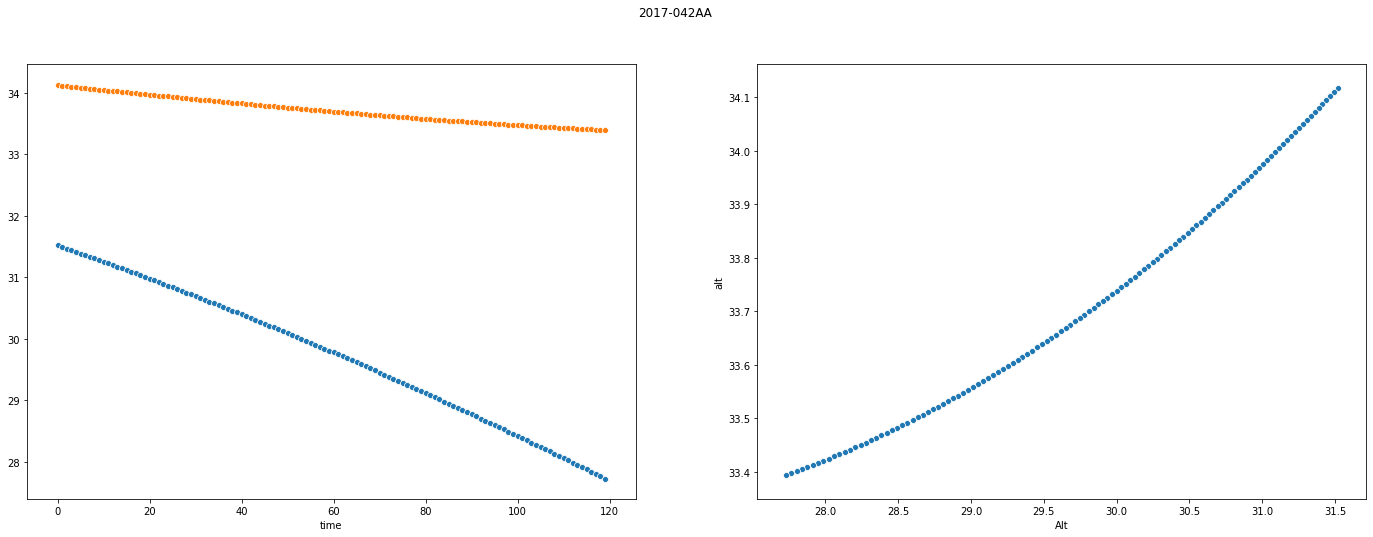

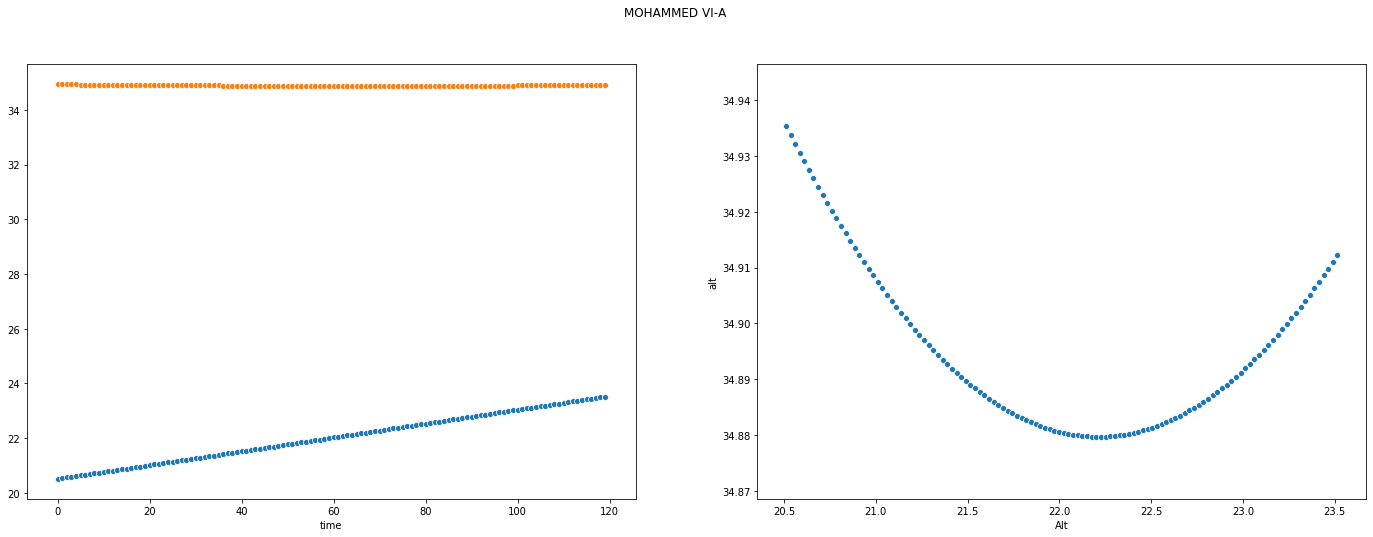

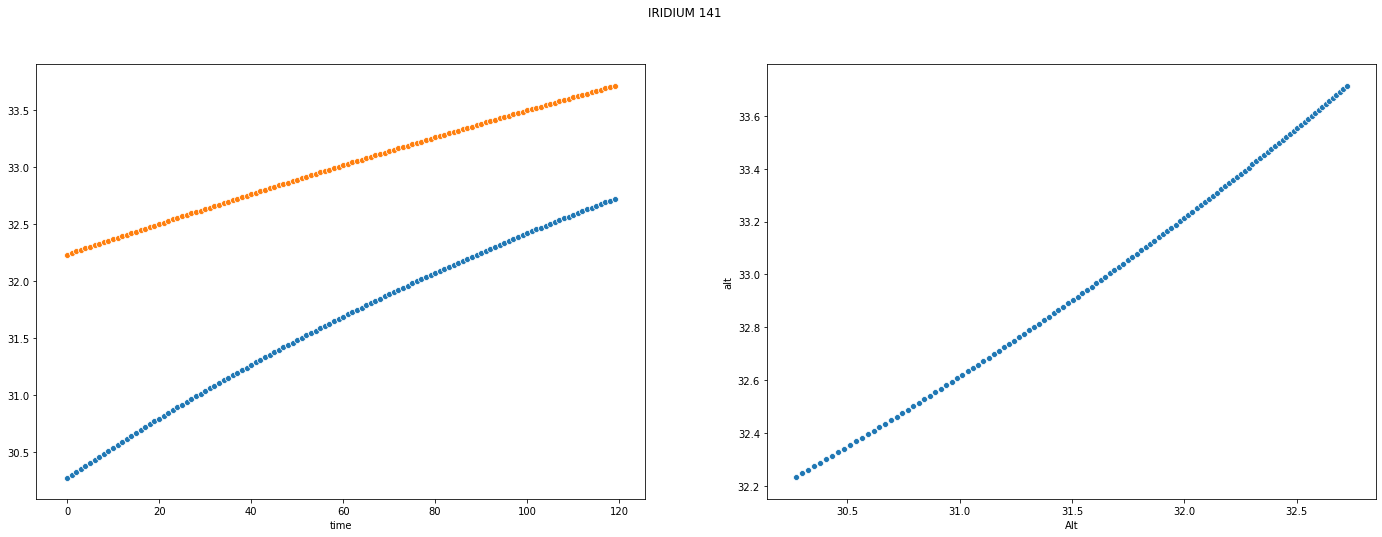

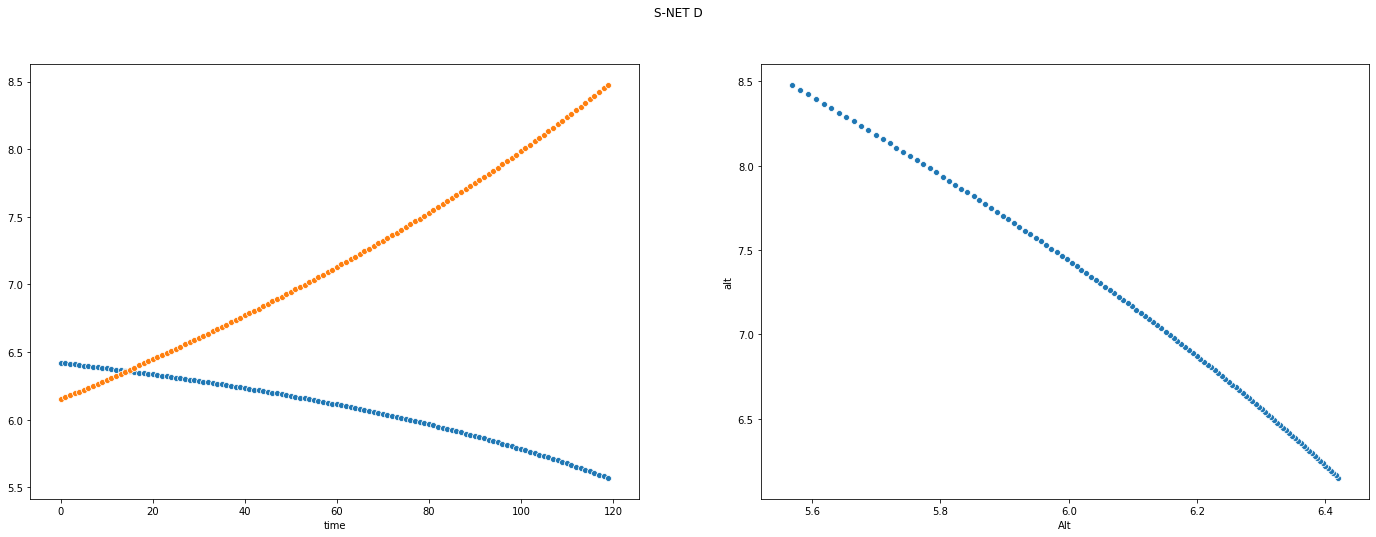

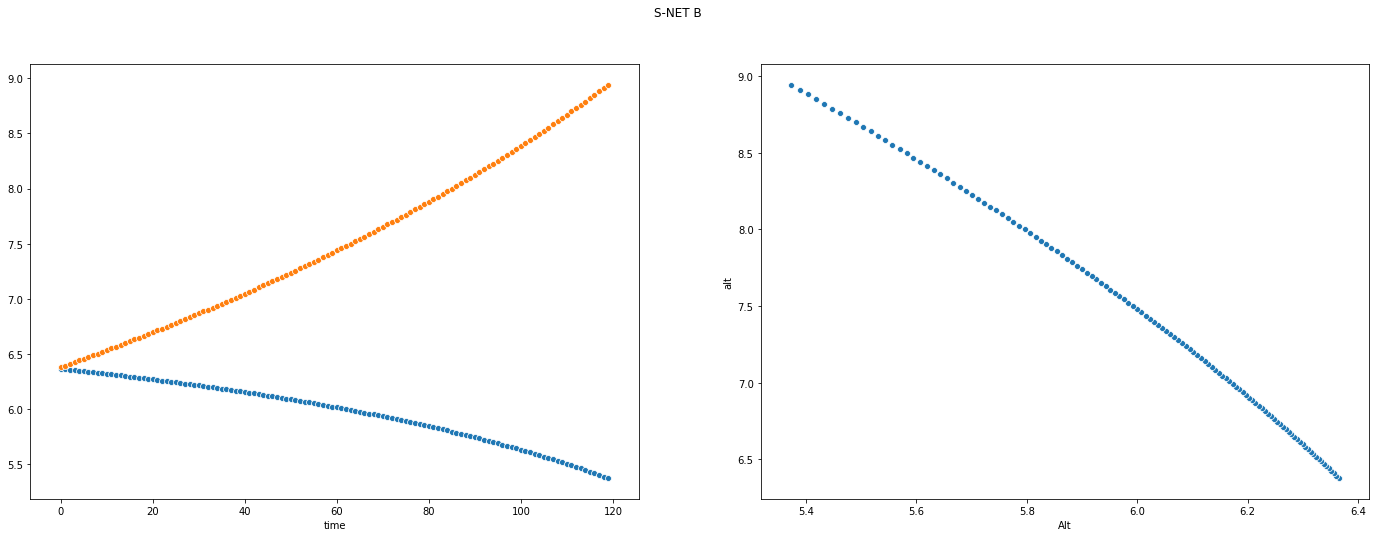

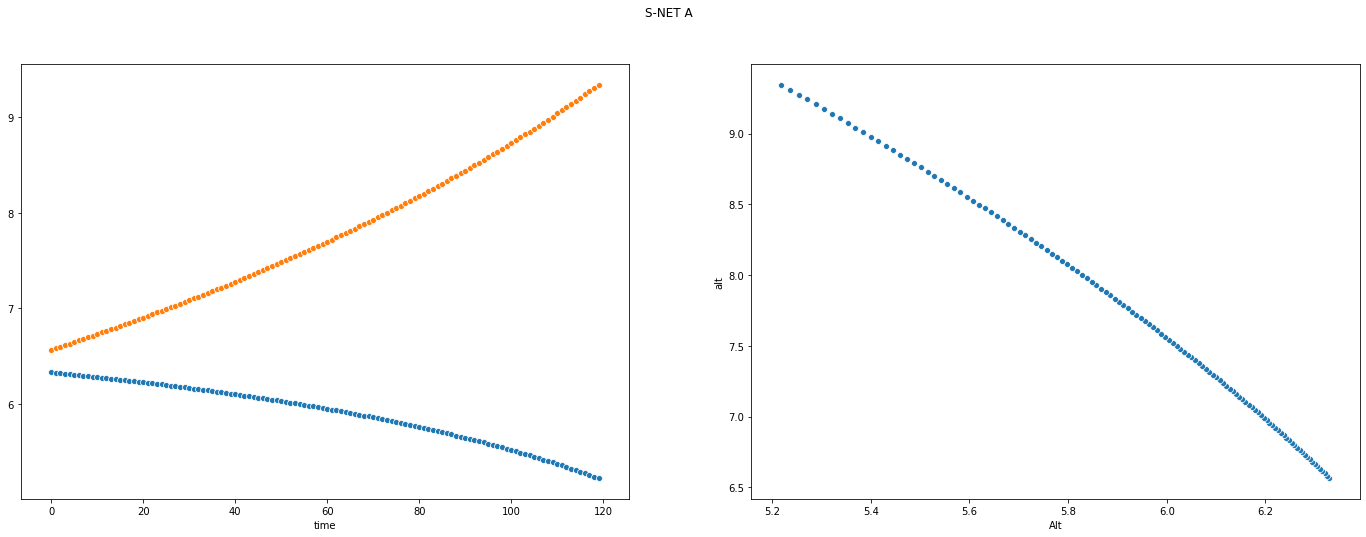

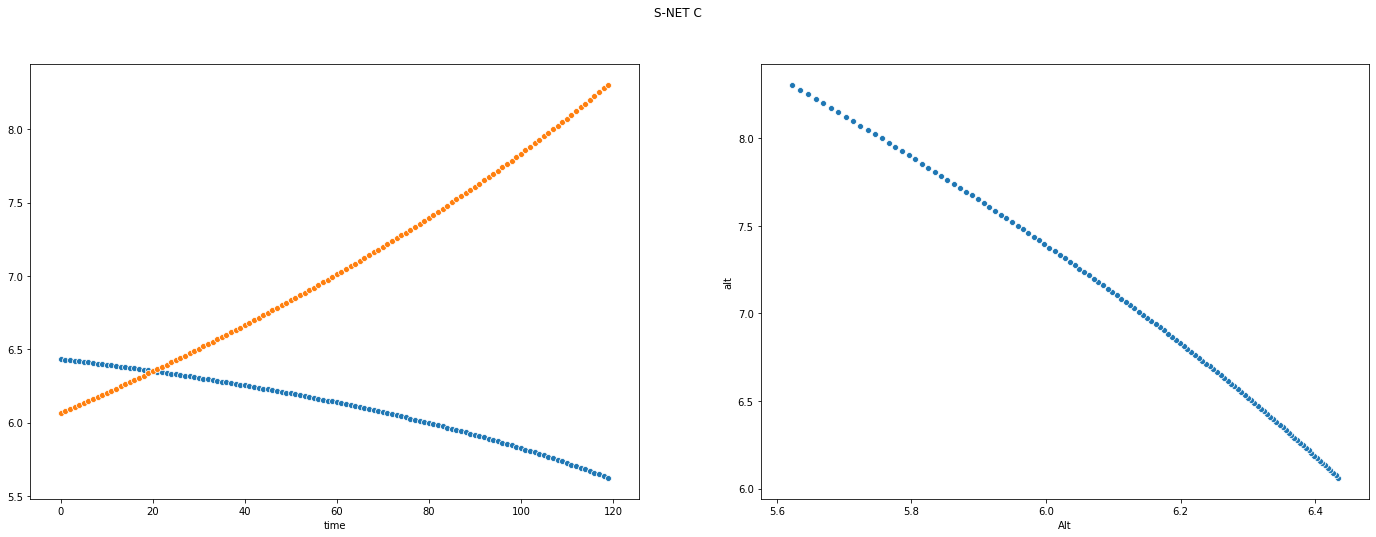

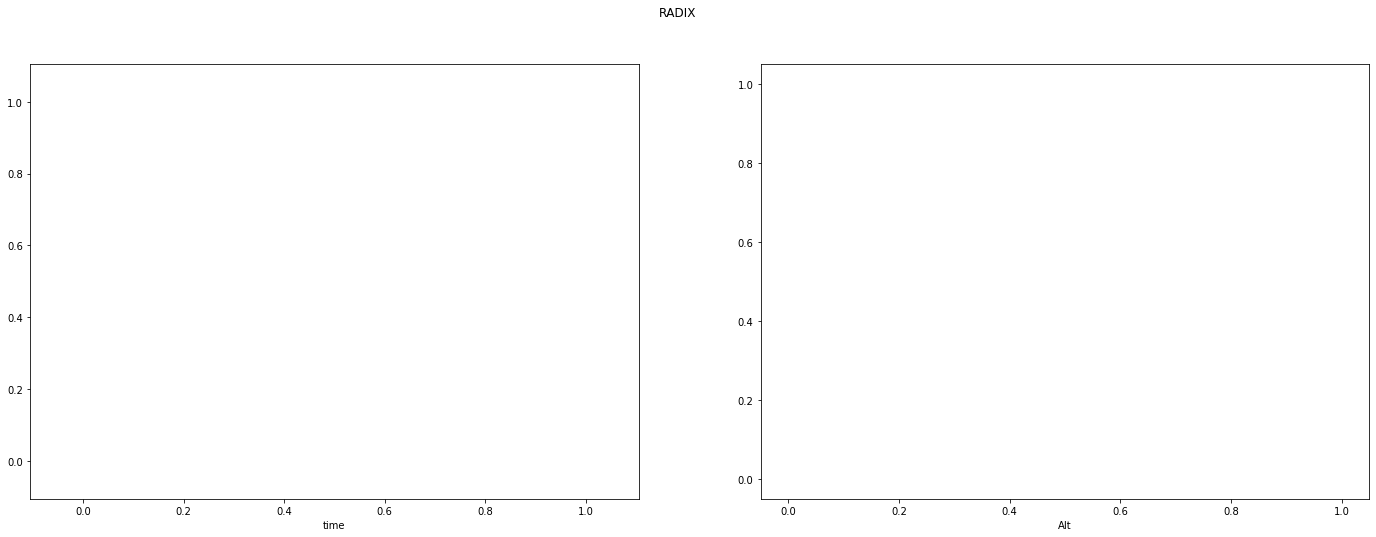

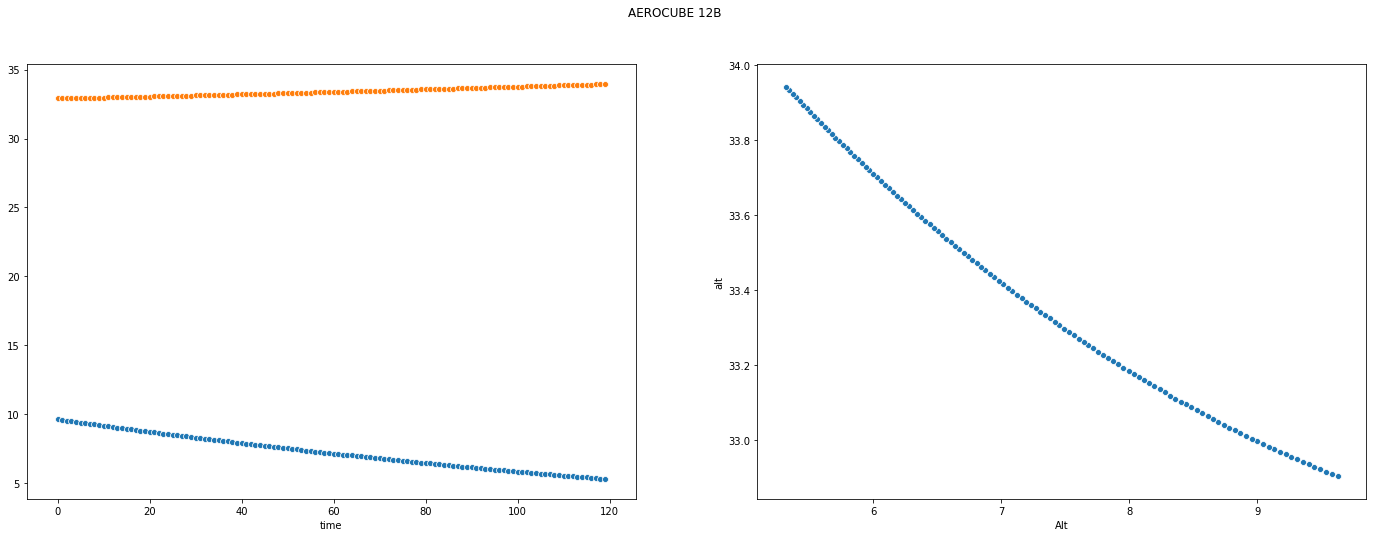

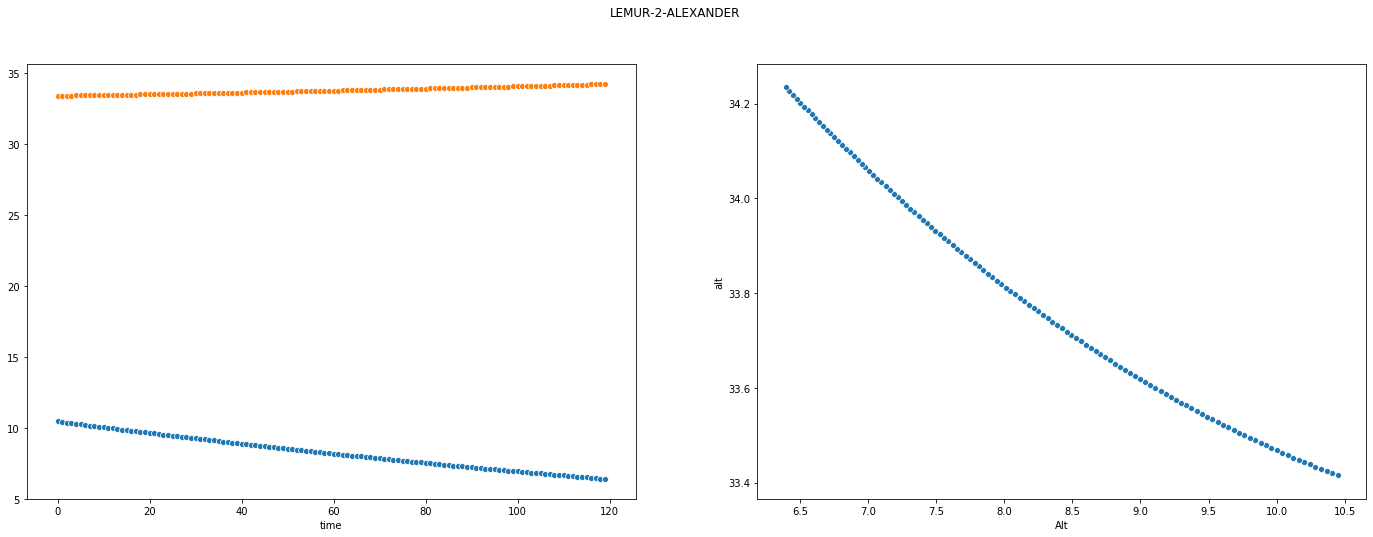

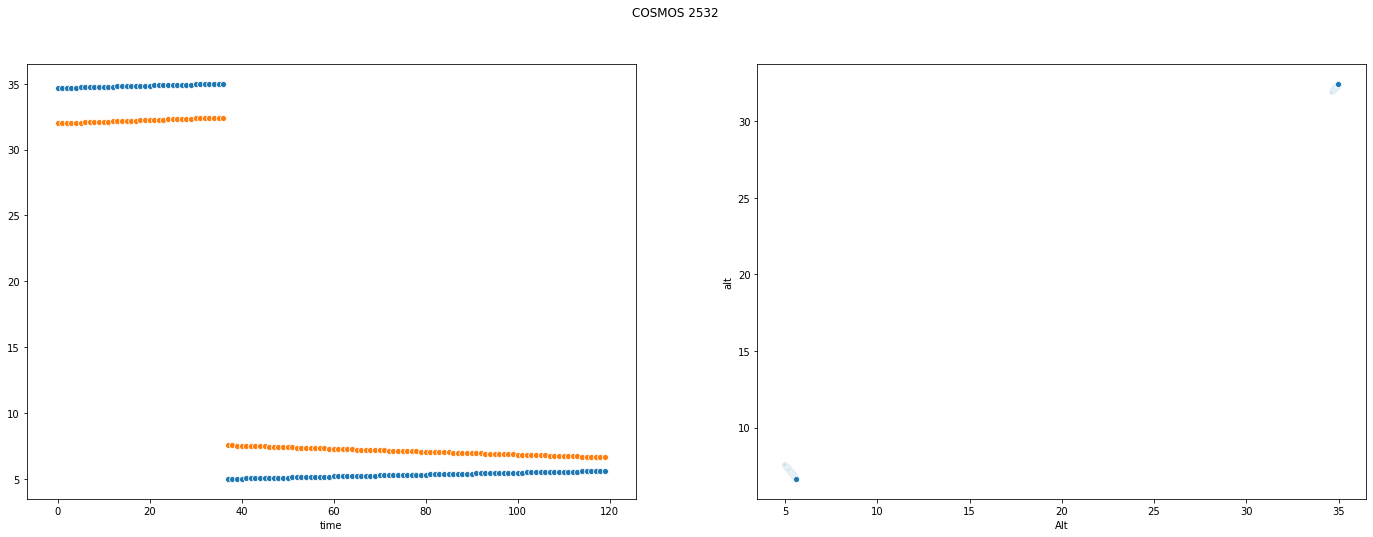

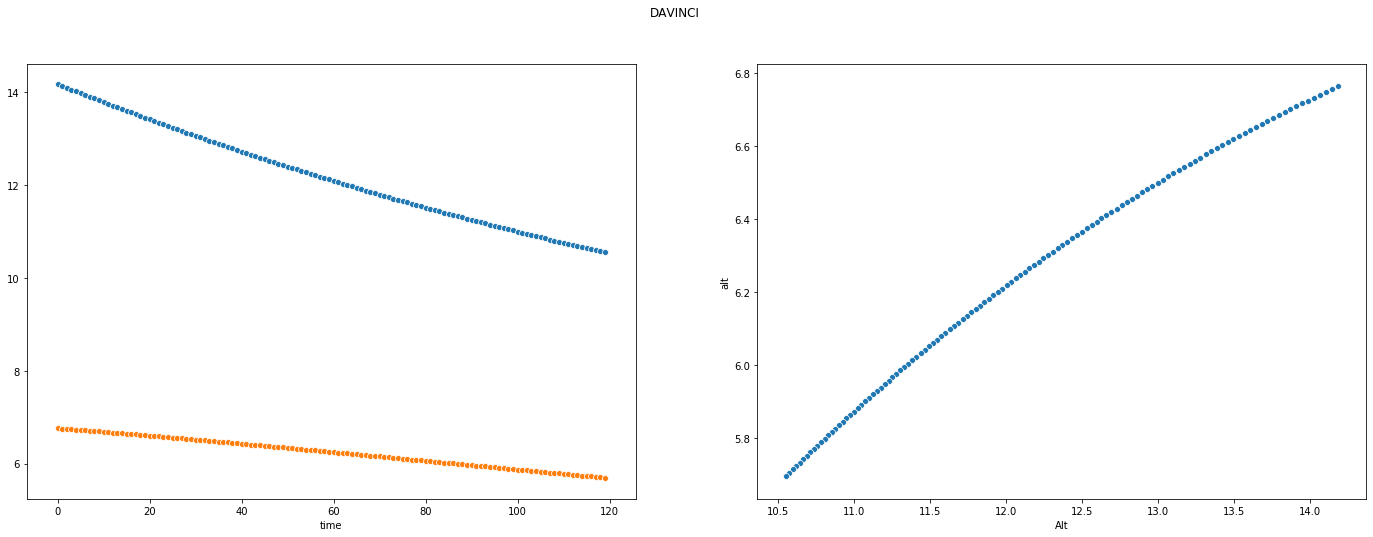

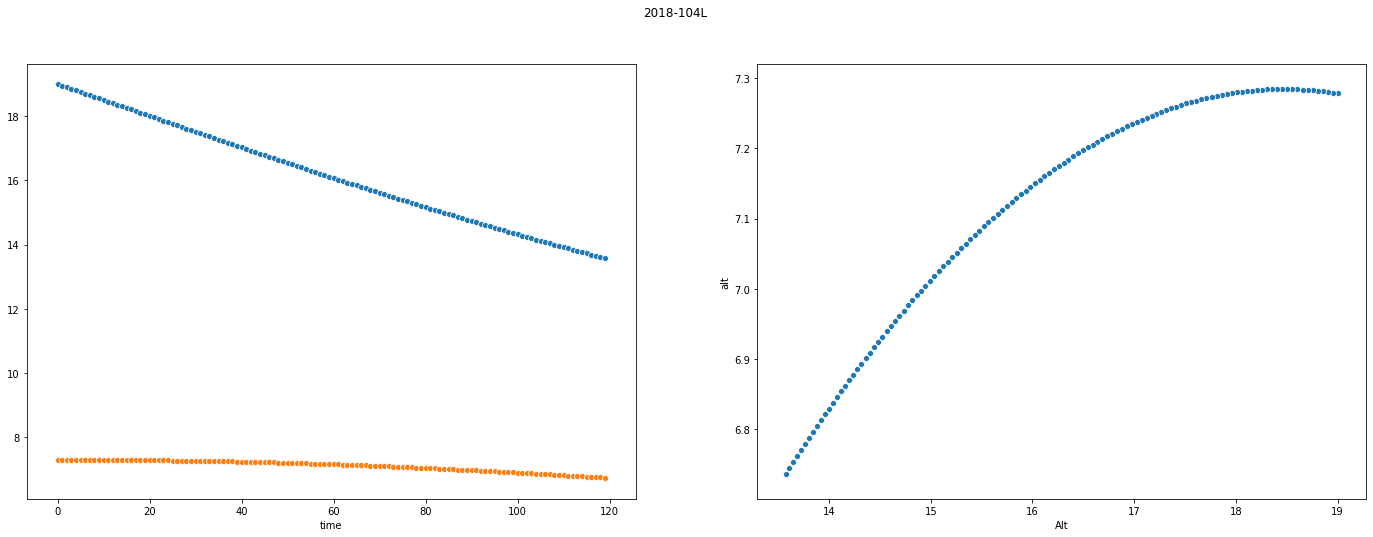

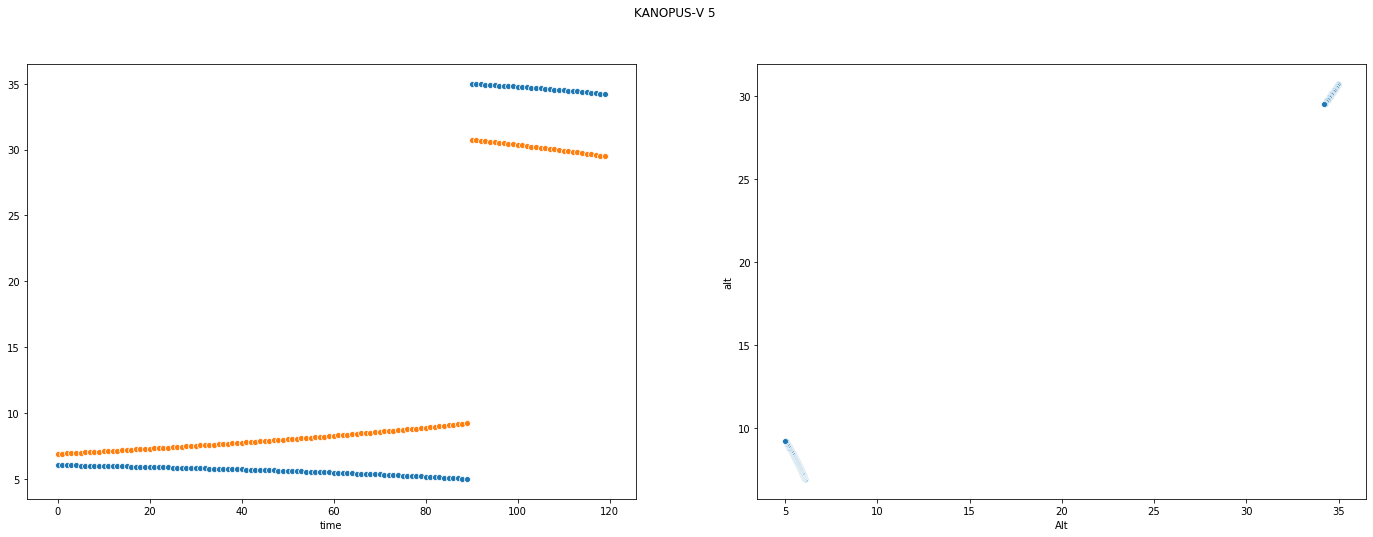

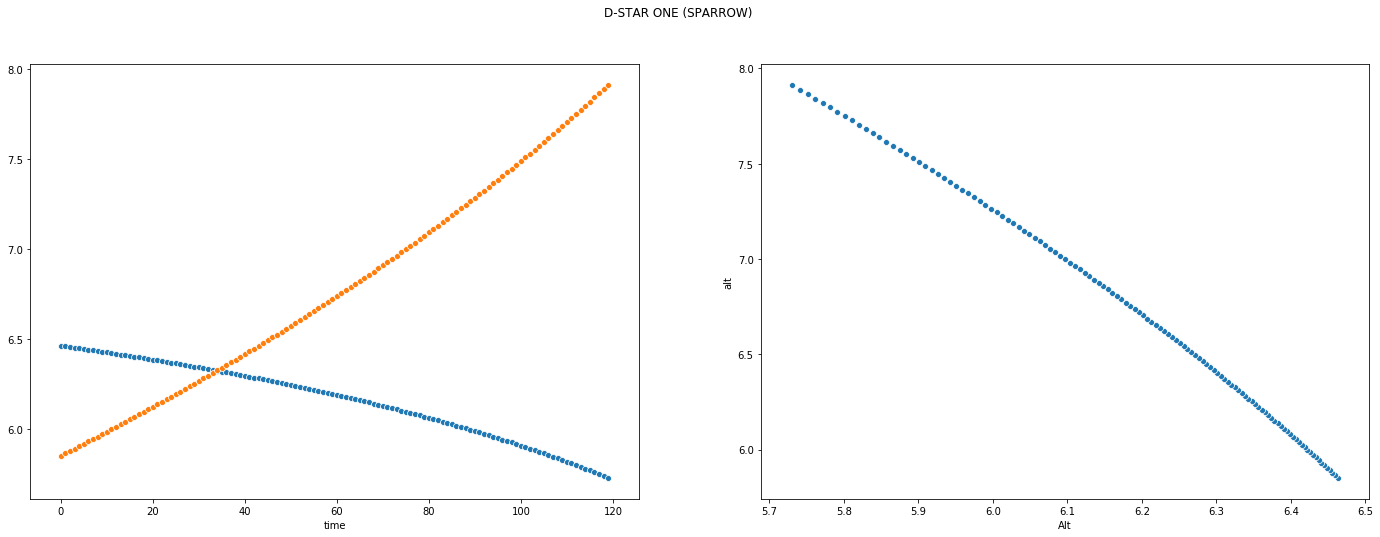

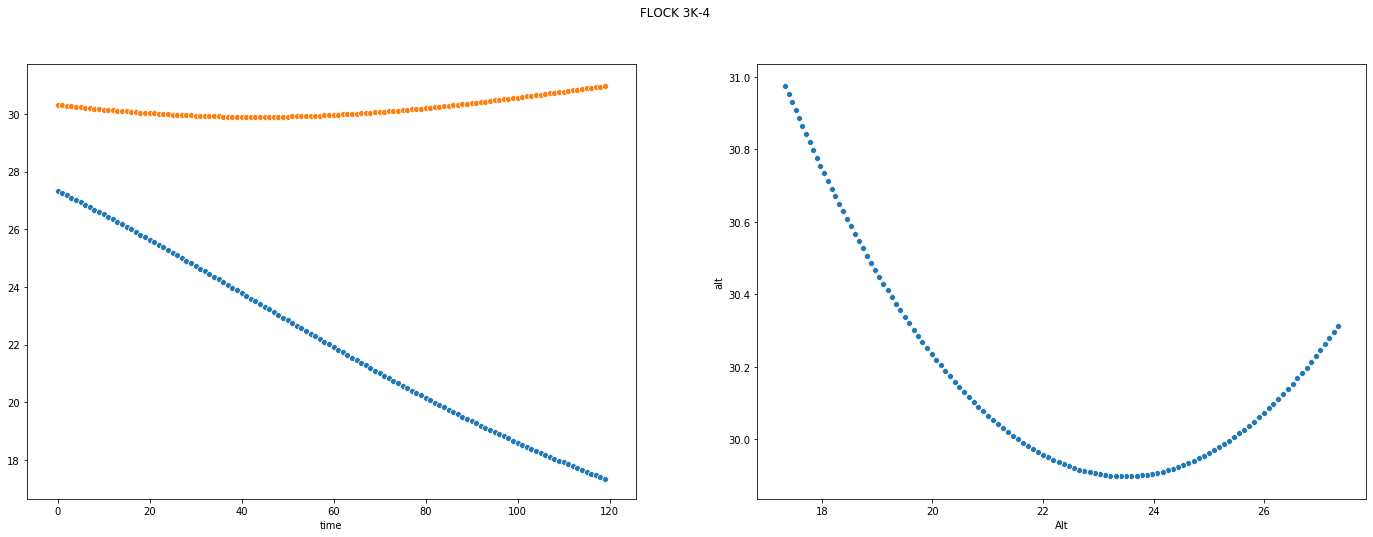

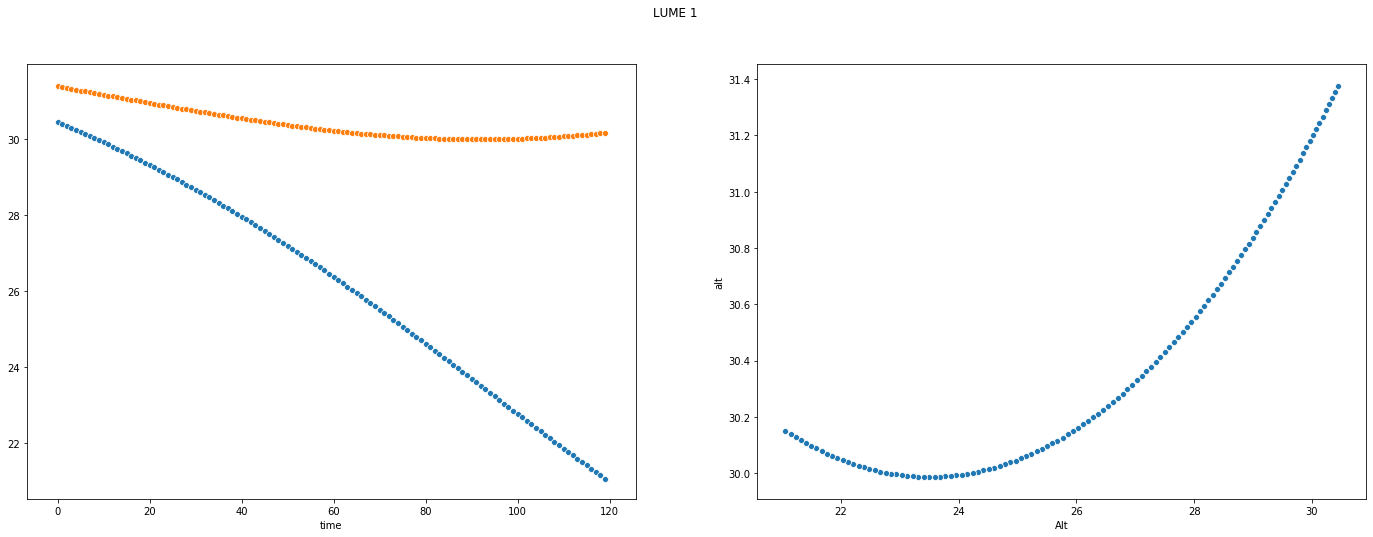

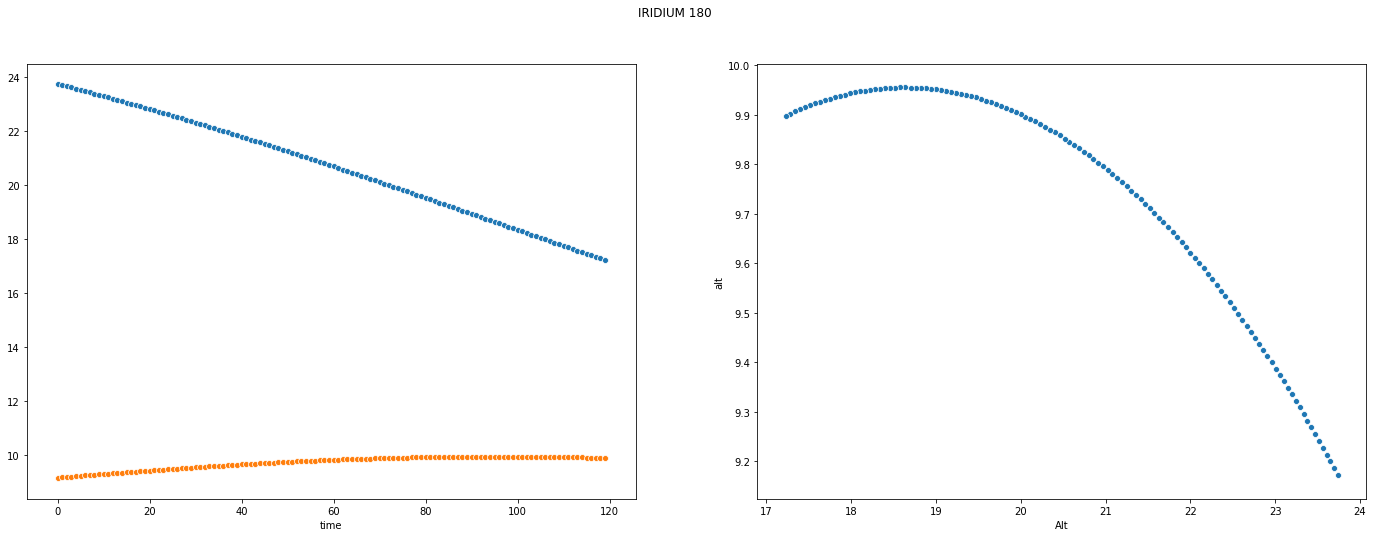

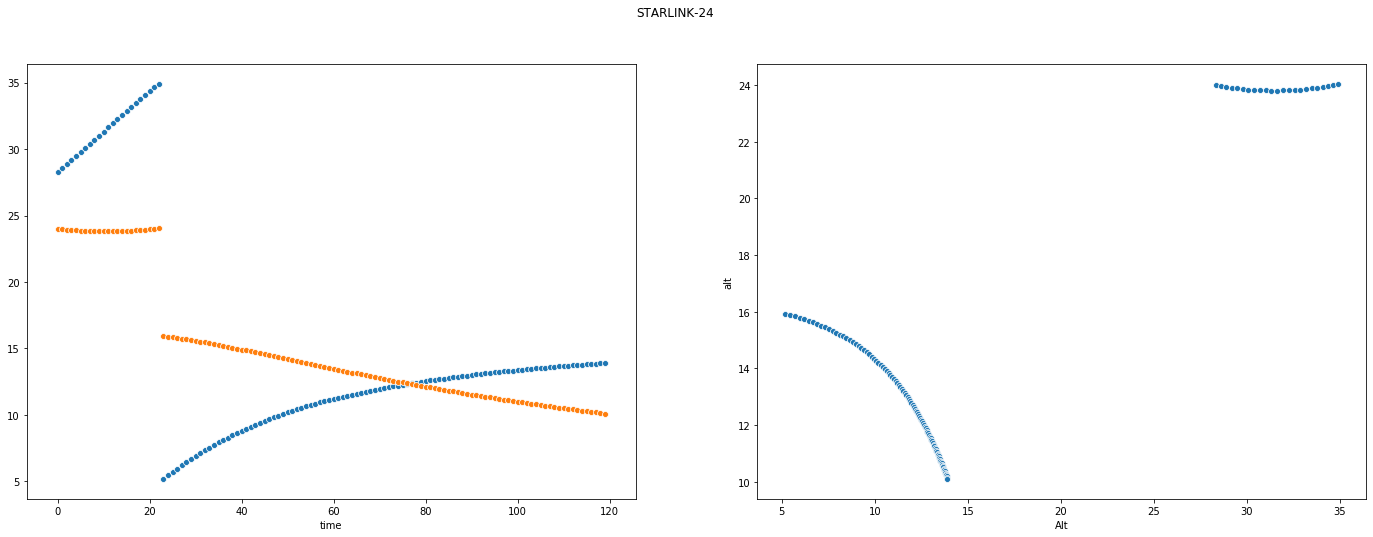

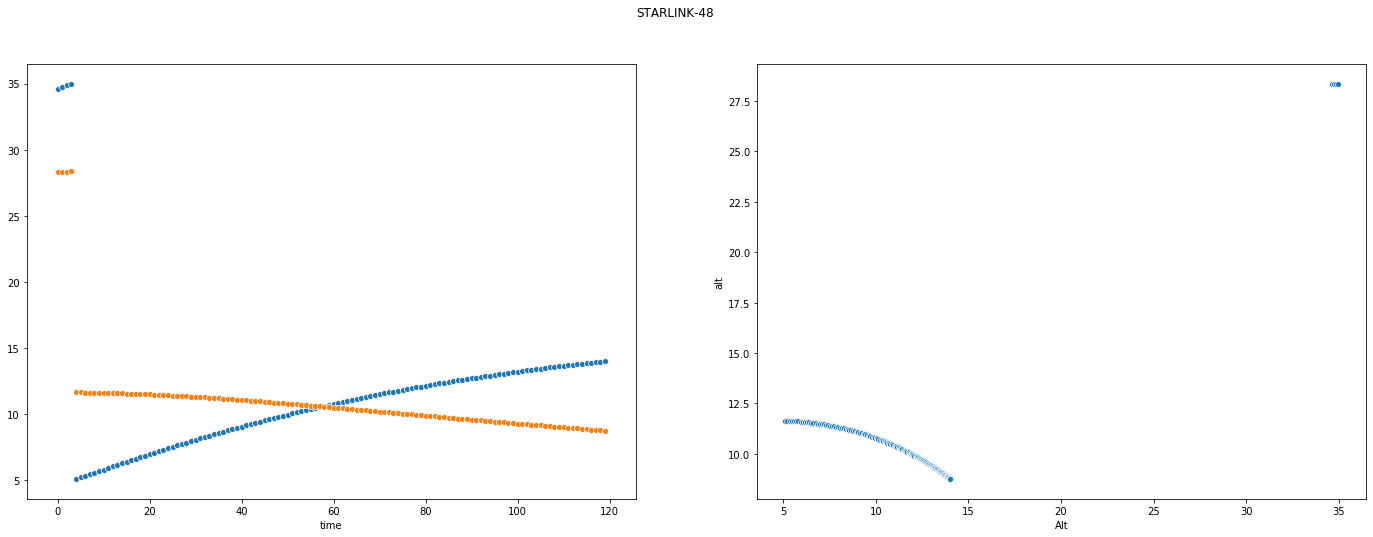

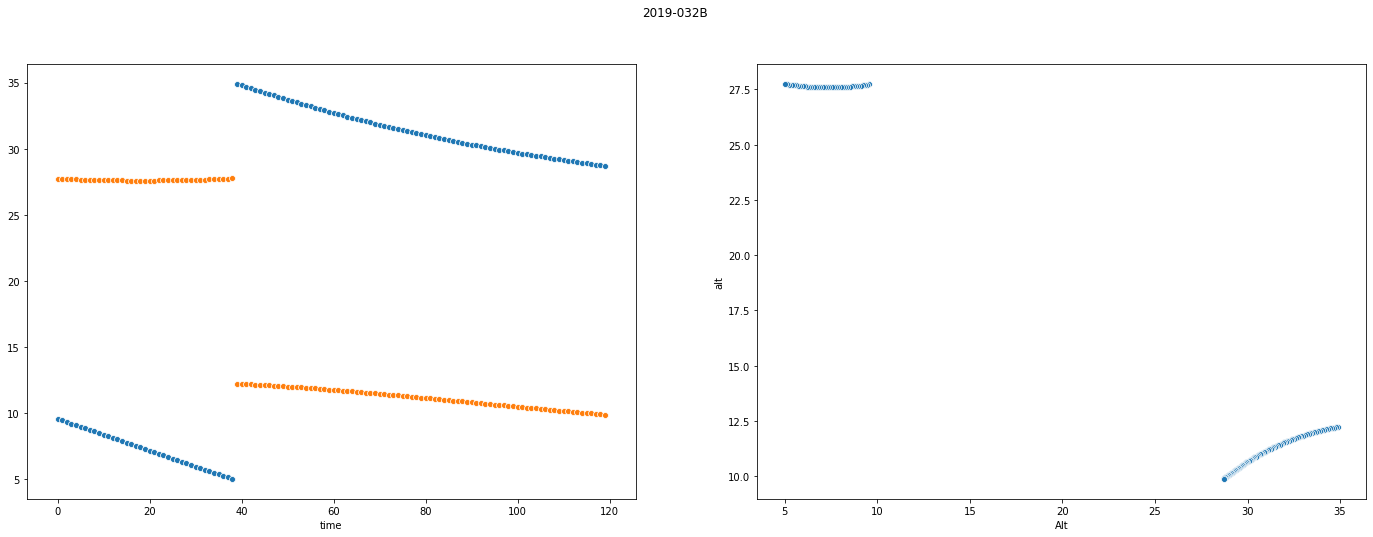

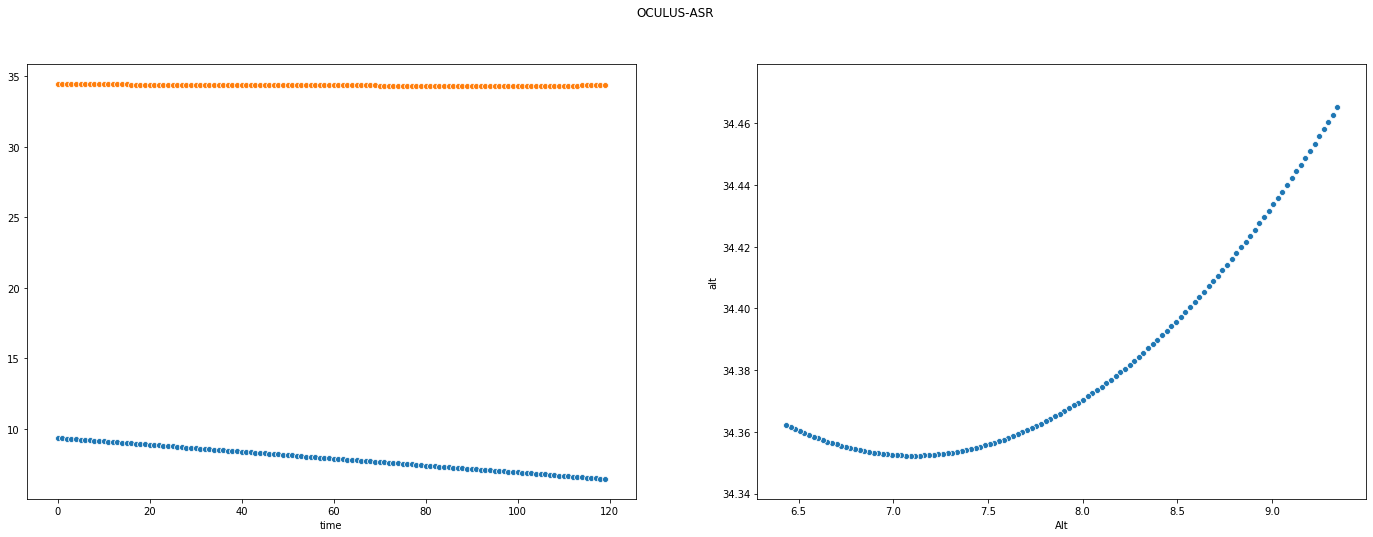

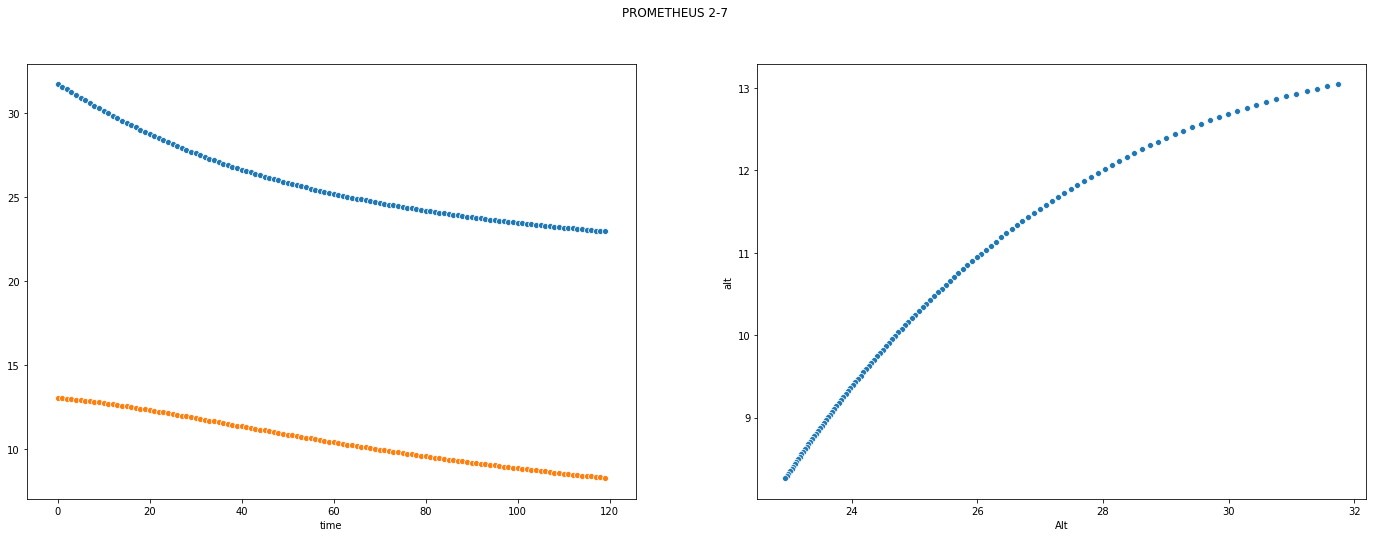

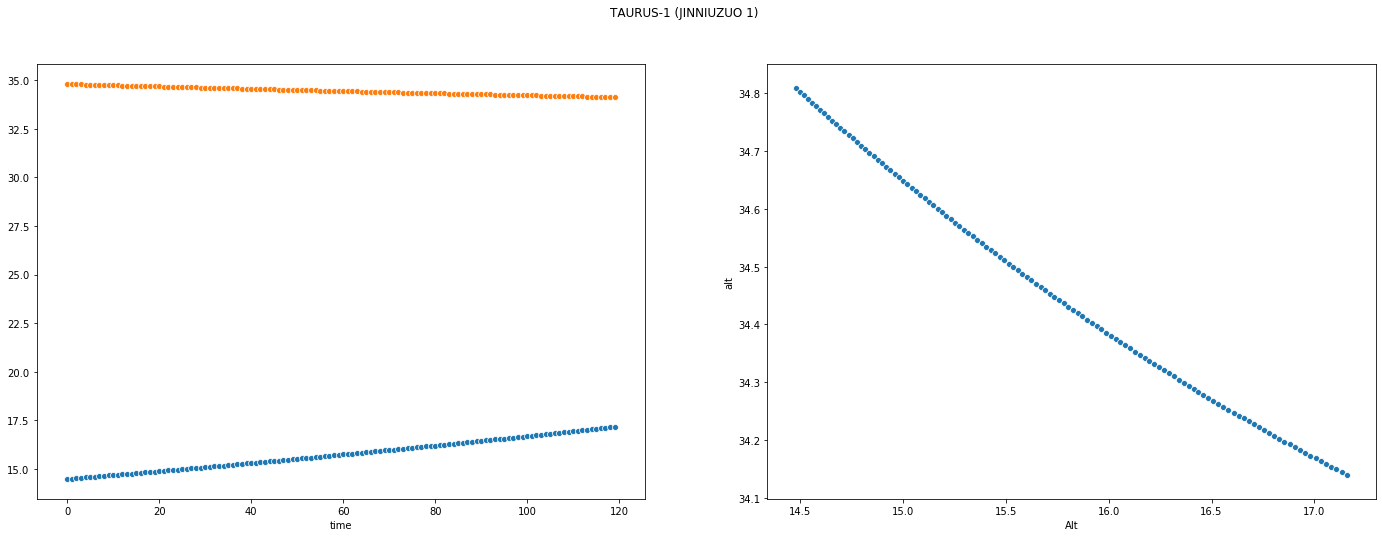

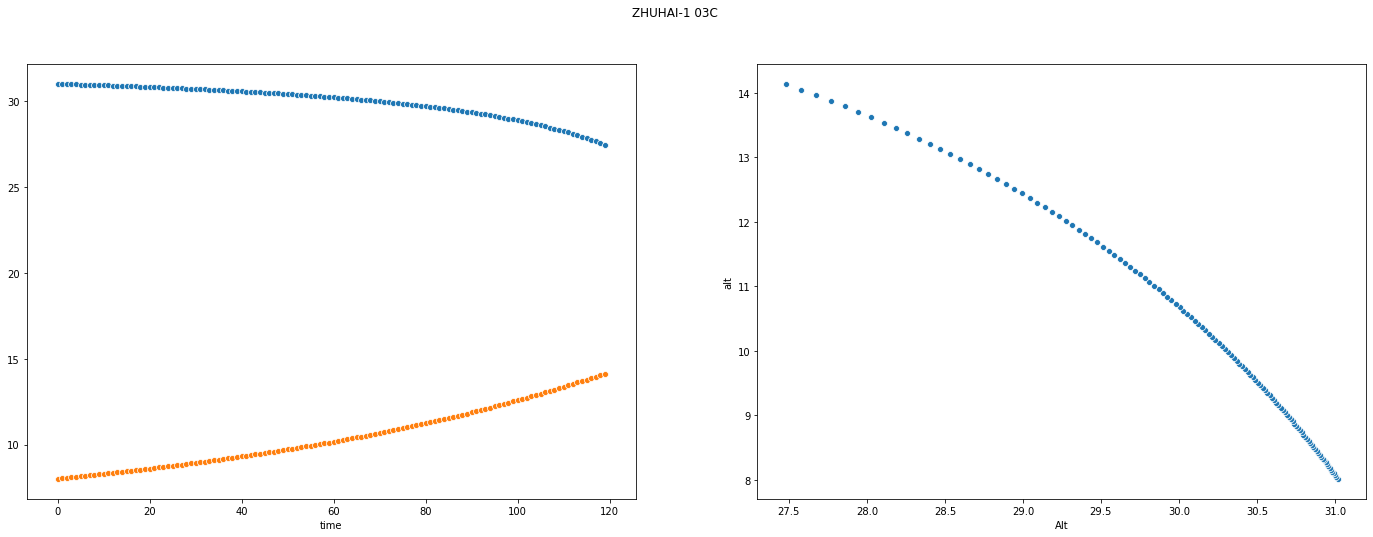

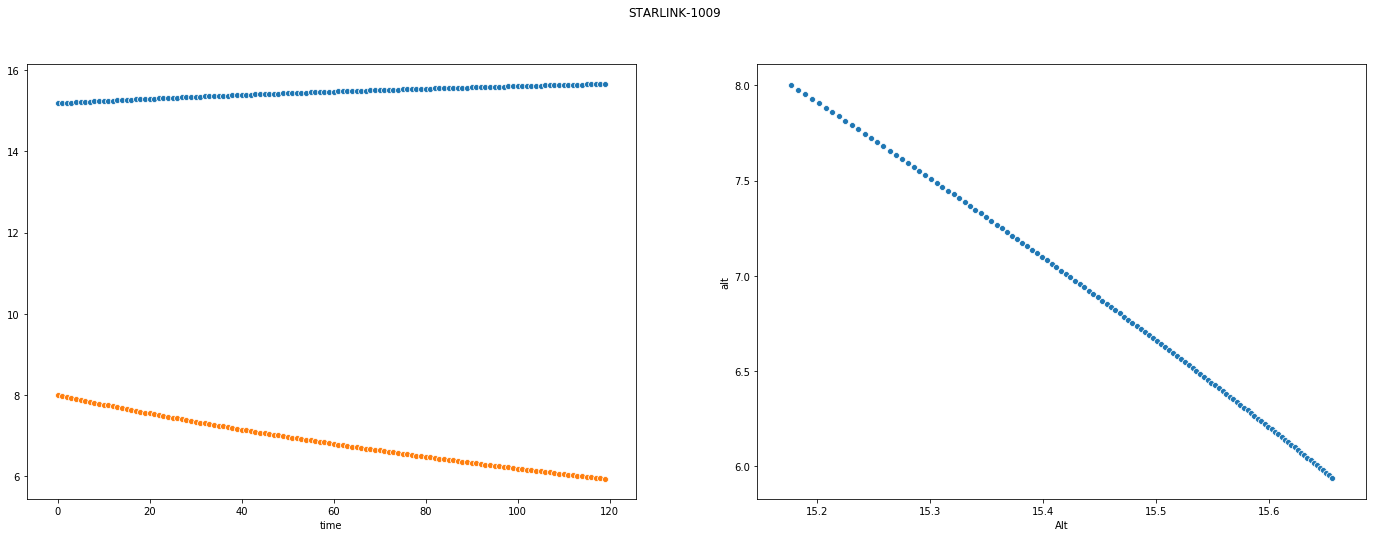

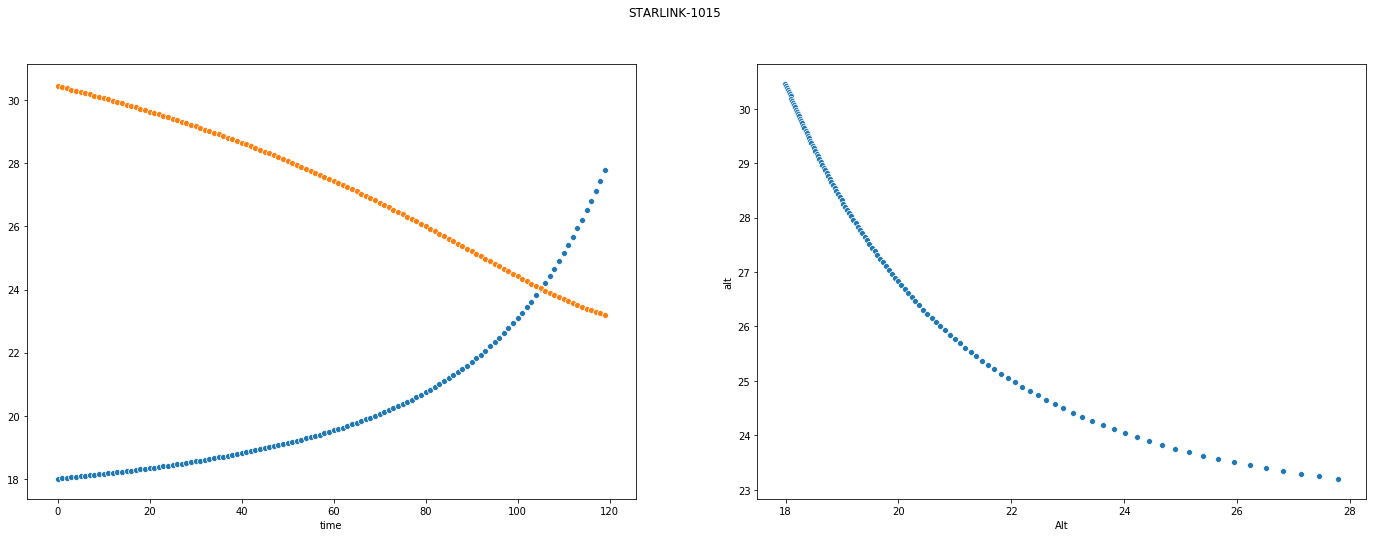

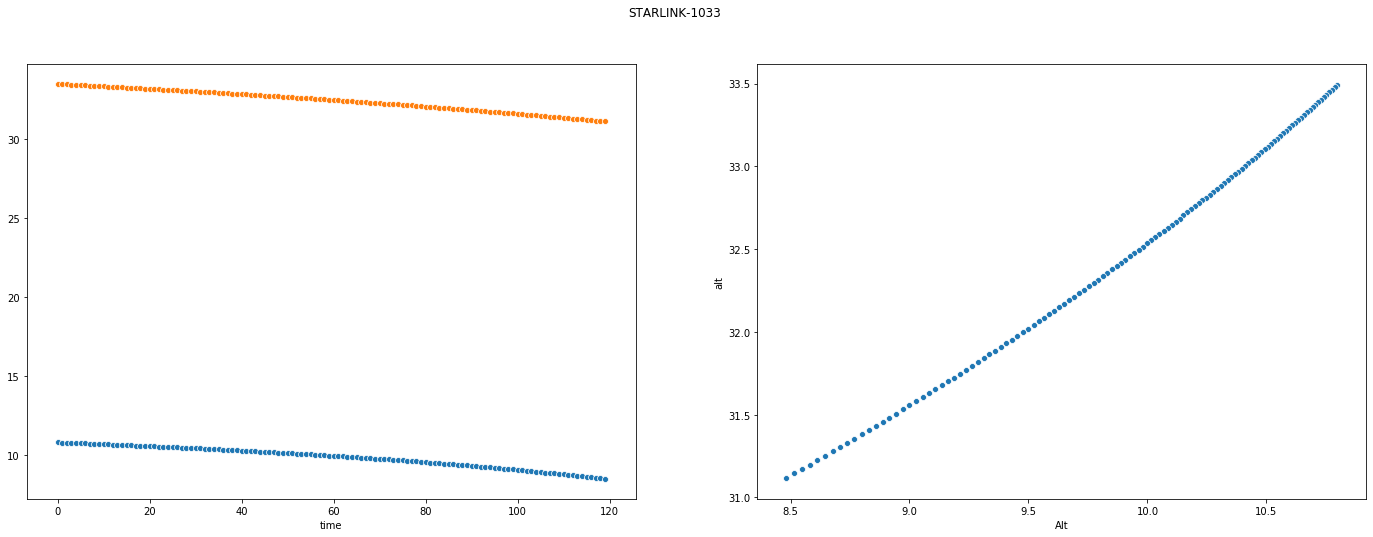

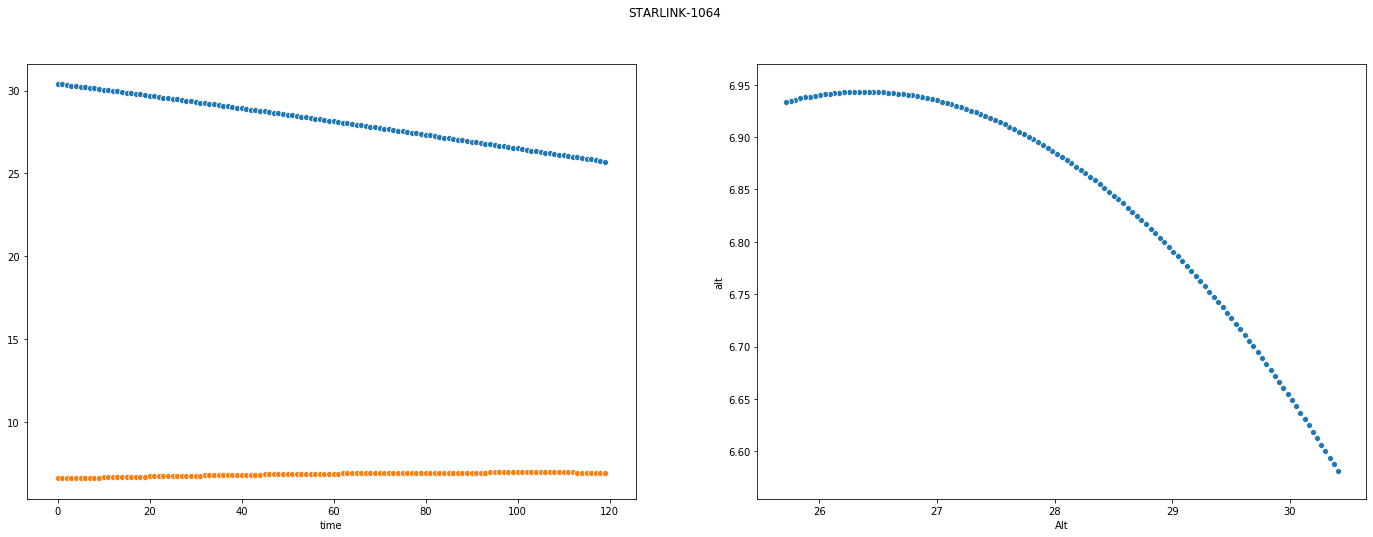

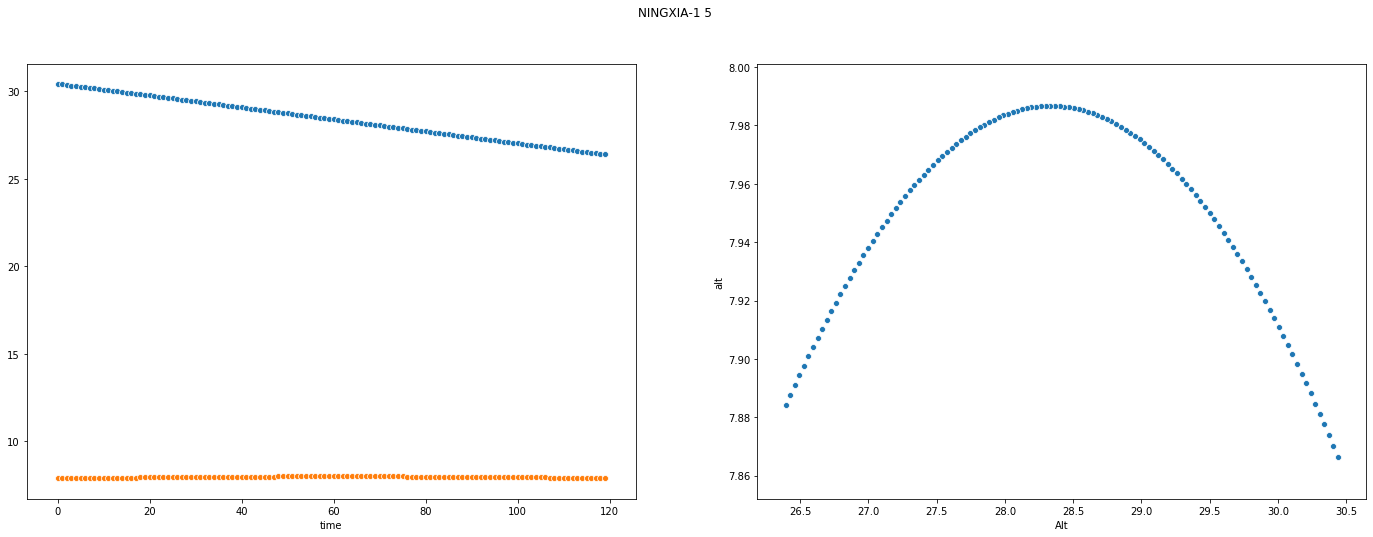

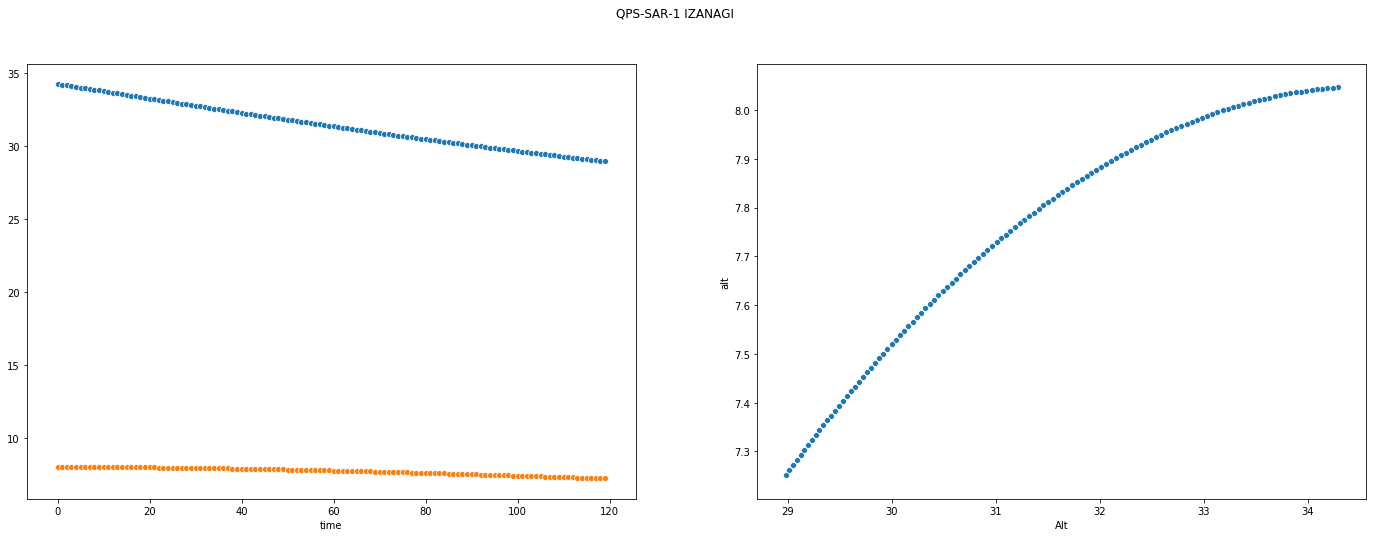

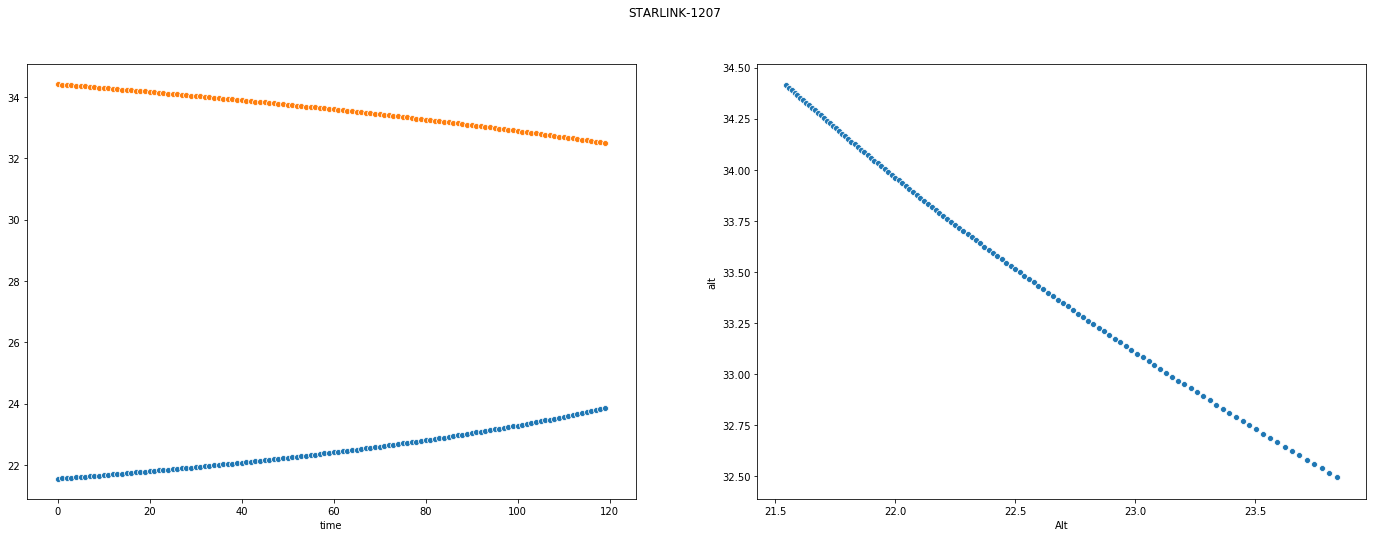

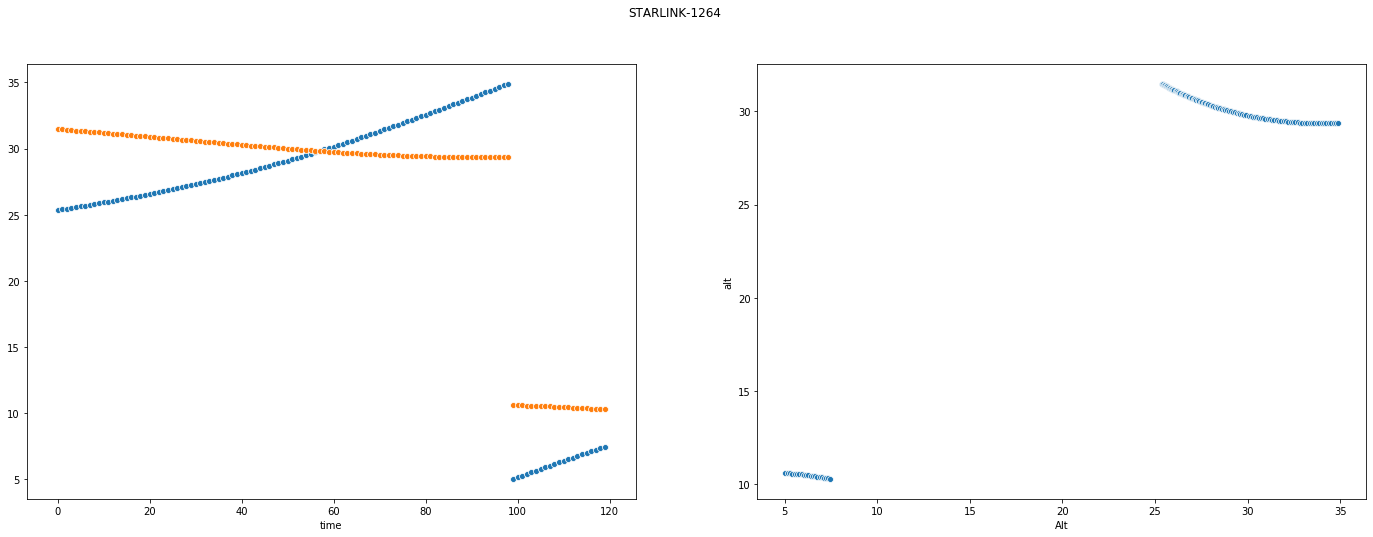

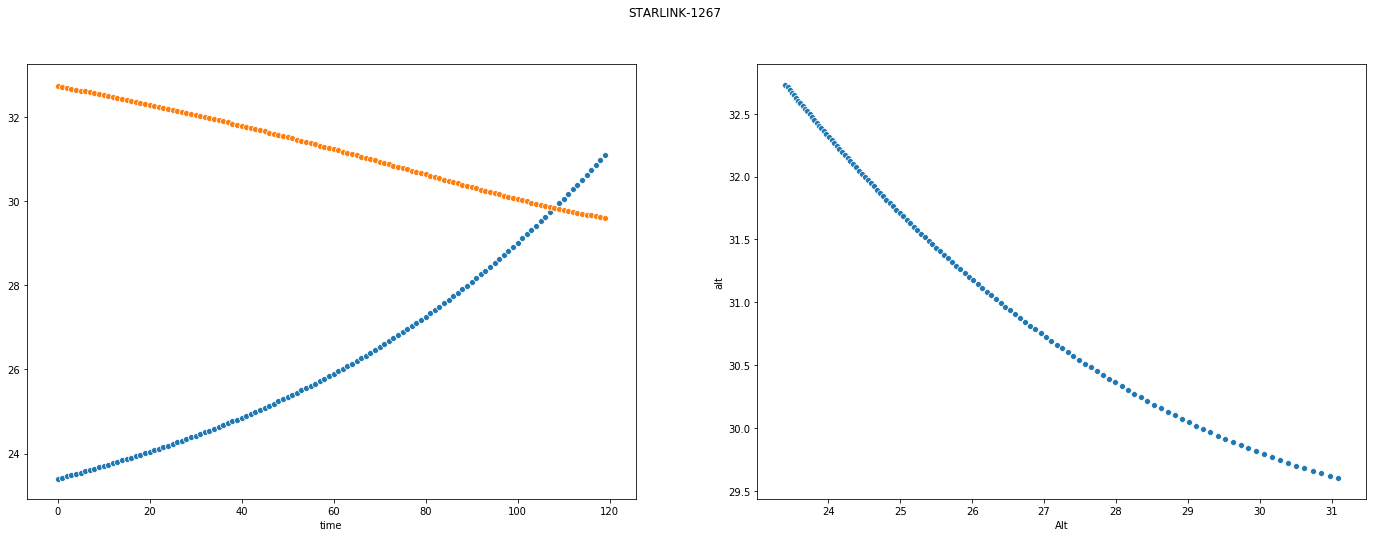

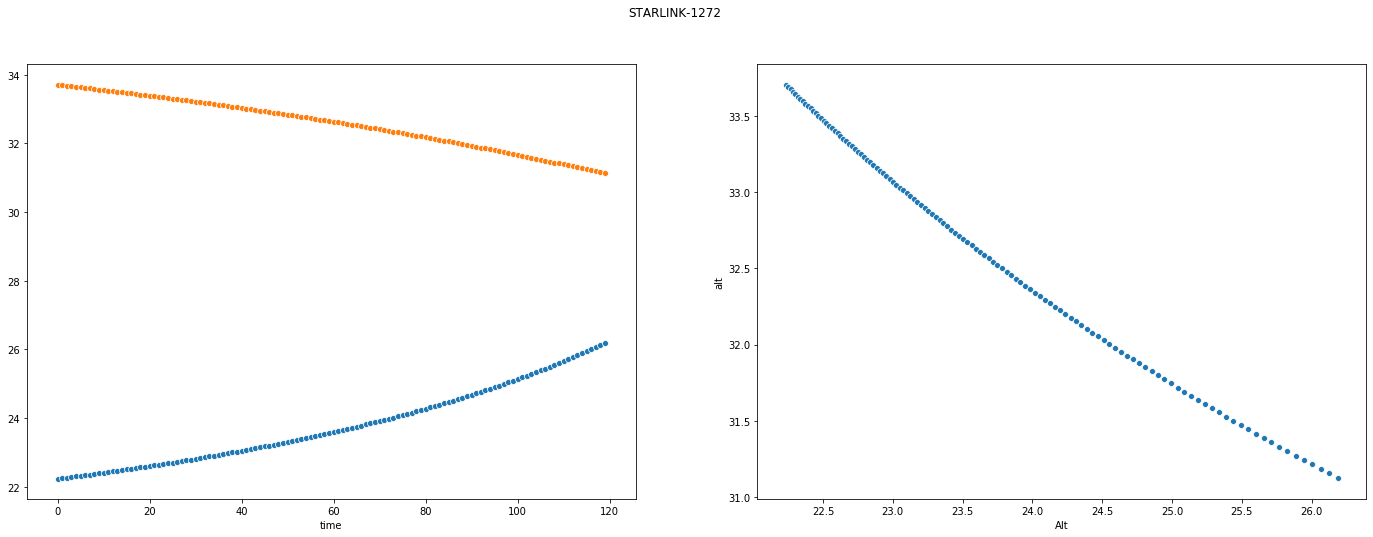

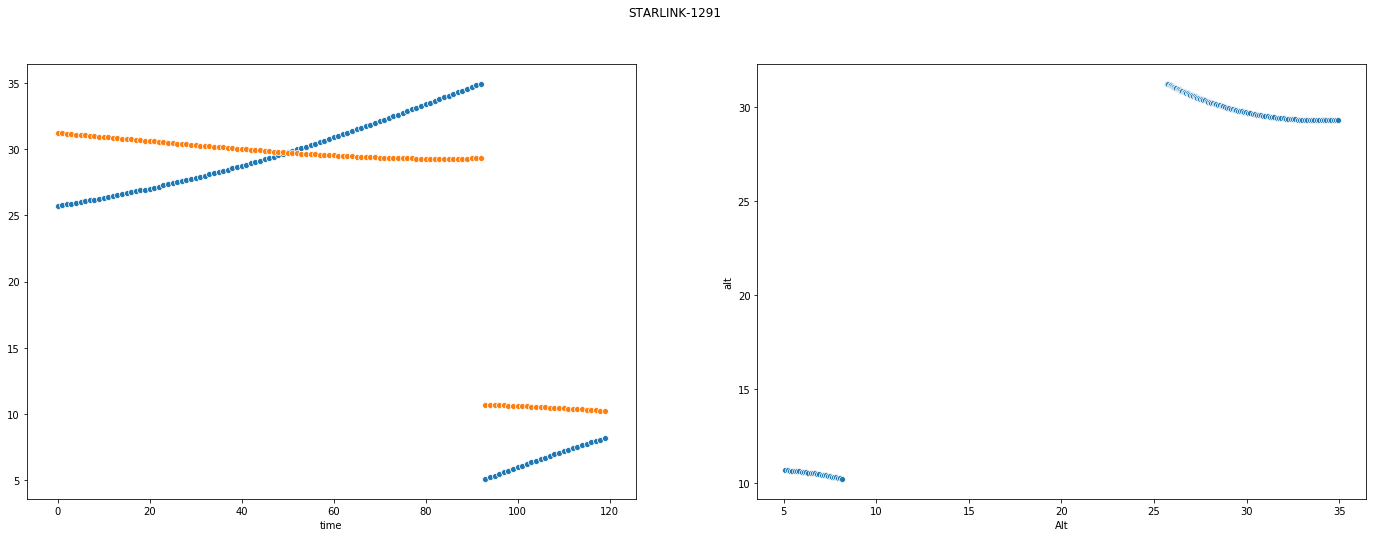

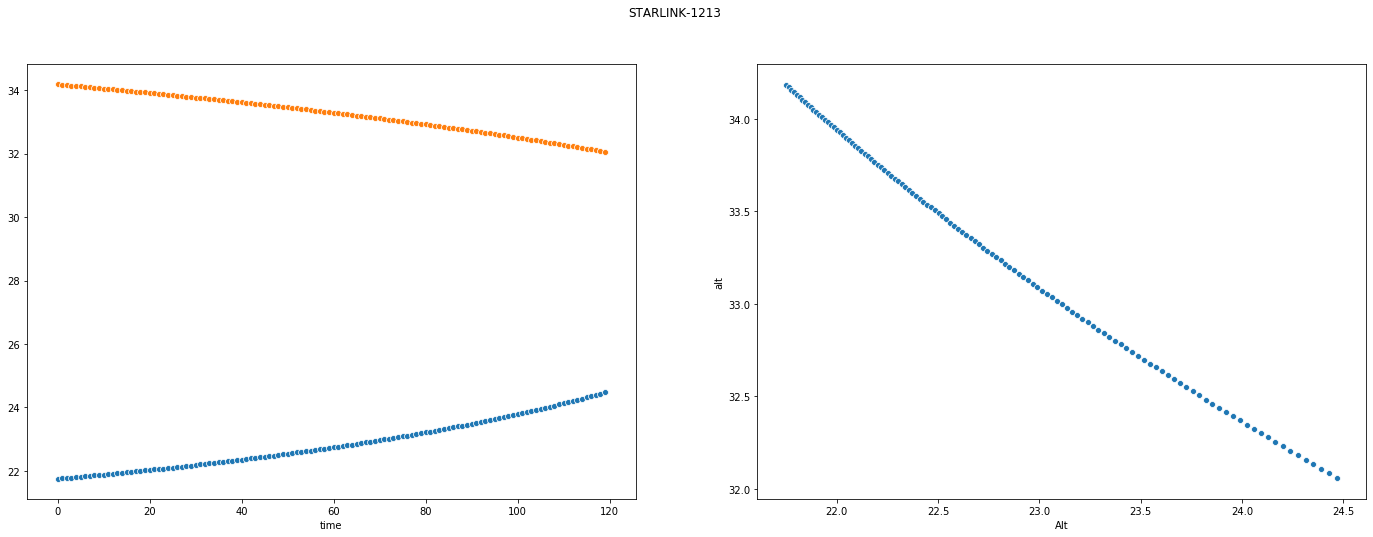

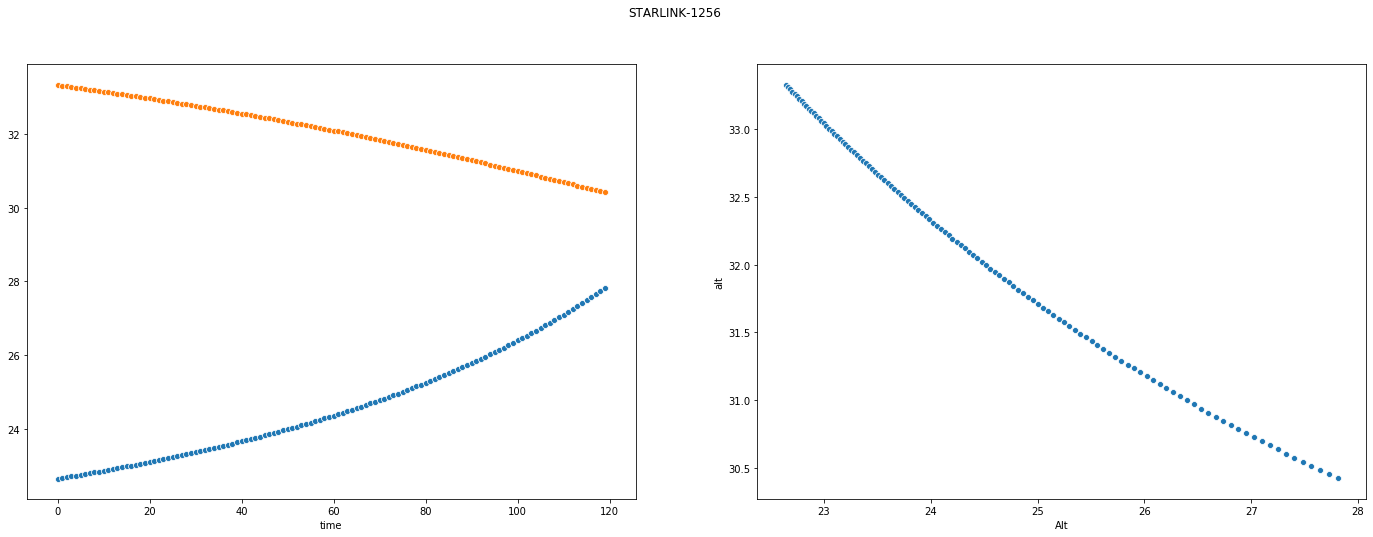

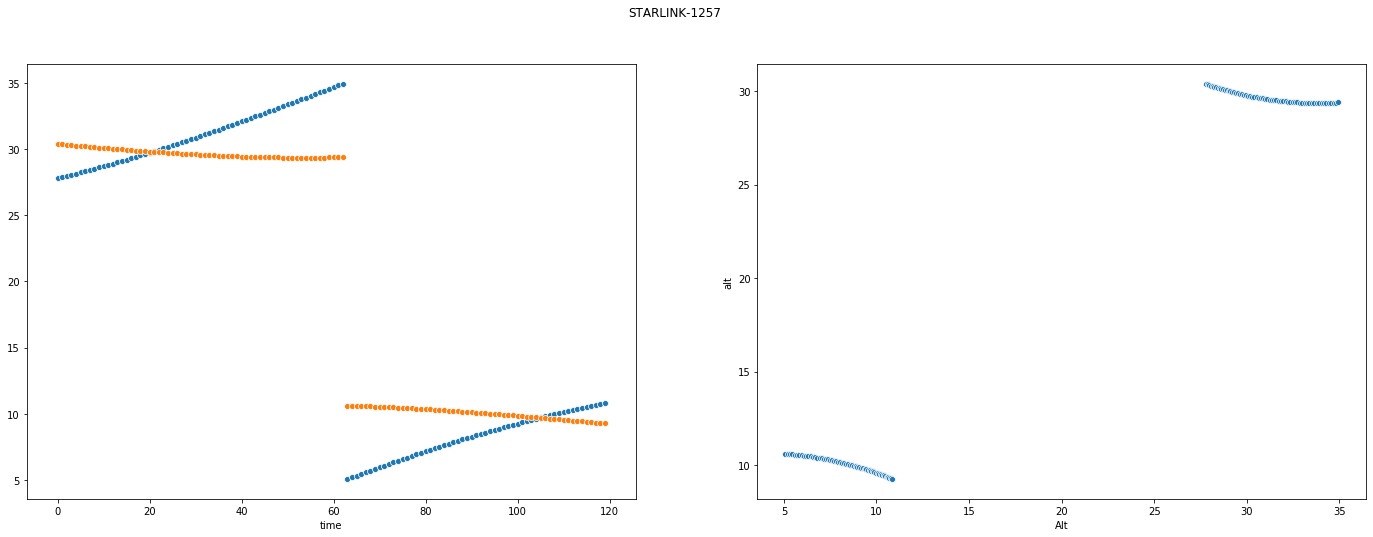

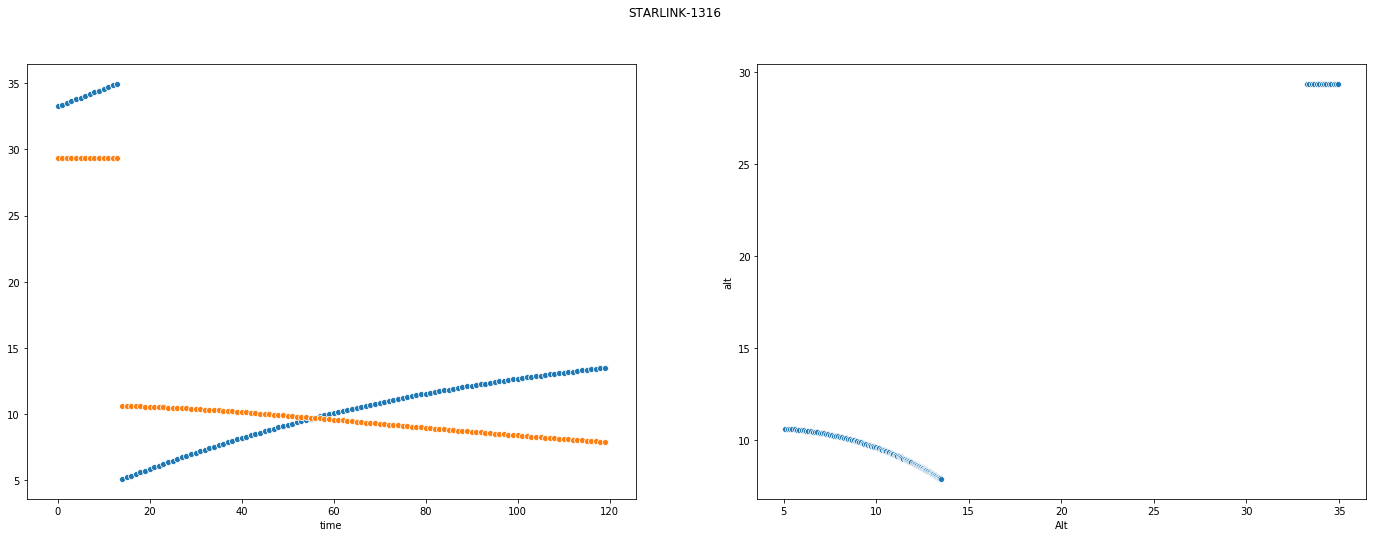

In [4]:
for name, sat in sat_df.items():
    az = sat["az"]
    alt = sat["alt"]
    
    # filter out satellites with barely any movement
    if abs(az.quantile(0.25) - az.quantile(0.75)) < 1:
        if abs(alt.quantile(0.25) - alt.quantile(0.75)) < 1:
            continue
    plot_sat(sat, label=name)